<a href="https://colab.research.google.com/github/AliyeDogen/Multi-Class-Text-Classification/blob/main/Cok_Sinifli_Metin_Siniflandirma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow --quiet

In [ ]:
!pip install gradio --quiet

In [ ]:
!pip3 install openai --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string
import random
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import json
import openai

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Drive'ı ilişkilendirme**

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/NLP_Studies"

In [ ]:
%ls

**Sık kullanılan kelimeleri ekleme**

In [ ]:
tr_stop_words = pd.read_csv('tr_stop_word.txt',header=None)
print("First 5 entries:")
for each in tr_stop_words.values[:5]:
  print(each[0])

**Veri setini yükleme**

In [ ]:
data = pd.read_csv('ticaret-yorum.csv')


**Bazı yorumlar ve ilişkili olduğu sınıflar**

In [ ]:
data.head()

,category,text
0,alisveris,Altus Hırdavat Yapı Malzemeleri Drone Diye Kar...
1,alisveris,"Albay Bilgisayar Garanti Yalanı İle Yanılttı,G..."
2,alisveris,"Okyanus Petshop Ürün İade Sorunu!,Satıcıdan Gi..."
3,alisveris,Anda İhtiyaç Ve Tüketim Maddeleri Knee Tork Di...
4,alisveris,BB Kargo Dağıtım'dan Aldığım Ürün Bozuk Çıktı ...


**Veri seti hakkında bilgi**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431306 entries, 0 to 431305
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  431306 non-null  object
 1   text      431306 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


**NULL değerleri kontrol etme var ise silme**

In [ ]:
data.isnull().sum()
#df.dropna(inplace=True)
#df.isnull().sum()

category    0
text        0
dtype: int64

**Tekrar eden verileri tespit etme**

In [ ]:
data.describe(include='all')

,category,text
count,431306,431306
unique,32,427231
top,kamu-hizmetleri,Akman Nikah Ve Balo Salonu Sözleşme Bedeli Kap...
freq,14009,154


In [ ]:
data = pd.DataFrame(data)

In [ ]:
data.duplicated(keep="first").value_counts()

False    517
dtype: int64

In [ ]:
data.drop_duplicates(subset="alisveris", keep="first", inplace=True, ignore_index=True)
data.describe()

KeyError: Index(['alisveris'], dtype='object')

**Konuları analiz etme**

In [ ]:
topic_list = data["Konu"]
print("Topics:\n", topic_list)

Topics:
 0                            LAMBA PATLAK
1                  DIŞ KAPI KİLİT ARIZALI
2      BUZ MAKİNESİ ÇALIŞMIYOR - ELEKTRIK
3                      VİDALANMASI TALEBİ
4             BULAŞIK MAKİNESİ ÇALIŞMIYOR
                      ...                
512                  BARİYER SABİTLENMESİ
513                    PRİNTER ÇALIŞMIYOR
514           ROOM CHANGE MINIBAR KONTROL
515                 CLUB CAR ŞARJ OLMUYOR
516             ACİL ÇIKIŞ BUTONU ARIZALI
Name: Konu, Length: 517, dtype: object


In [ ]:
data.to_csv('Konular.csv', index=False)

In [ ]:
number_of_topics = len(topic_list)
print("Number of Topics: ",number_of_topics)

Number of Topics:  517


**Konu başına yorum sayısı**

In [ ]:
data.category.value_counts()

category
kamu-hizmetleri              14009
finans                       13982
cep-telefon-kategori         13981
enerji                       13979
ulasim                       13957
kargo-nakliyat               13918
medya                        13910
mutfak-arac-gerec            13870
alisveris                    13835
mekan-ve-eglence             13810
elektronik                   13772
beyaz-esya                   13763
kucuk-ev-aletleri            13733
internet                     13694
giyim                        13690
etkinlik-ve-organizasyon     13655
icecek                       13564
saglik                       13560
sigortacilik                 13488
spor                         13449
mobilya-ev-tekstili          13434
otomotiv                     13379
turizm                       13318
egitim                       13269
gida                         13150
temizlik                     13113
hizmet-sektoru               13031
mucevher-saat-gozluk         12964
bilgisayar 

<Axes: xlabel='category'>

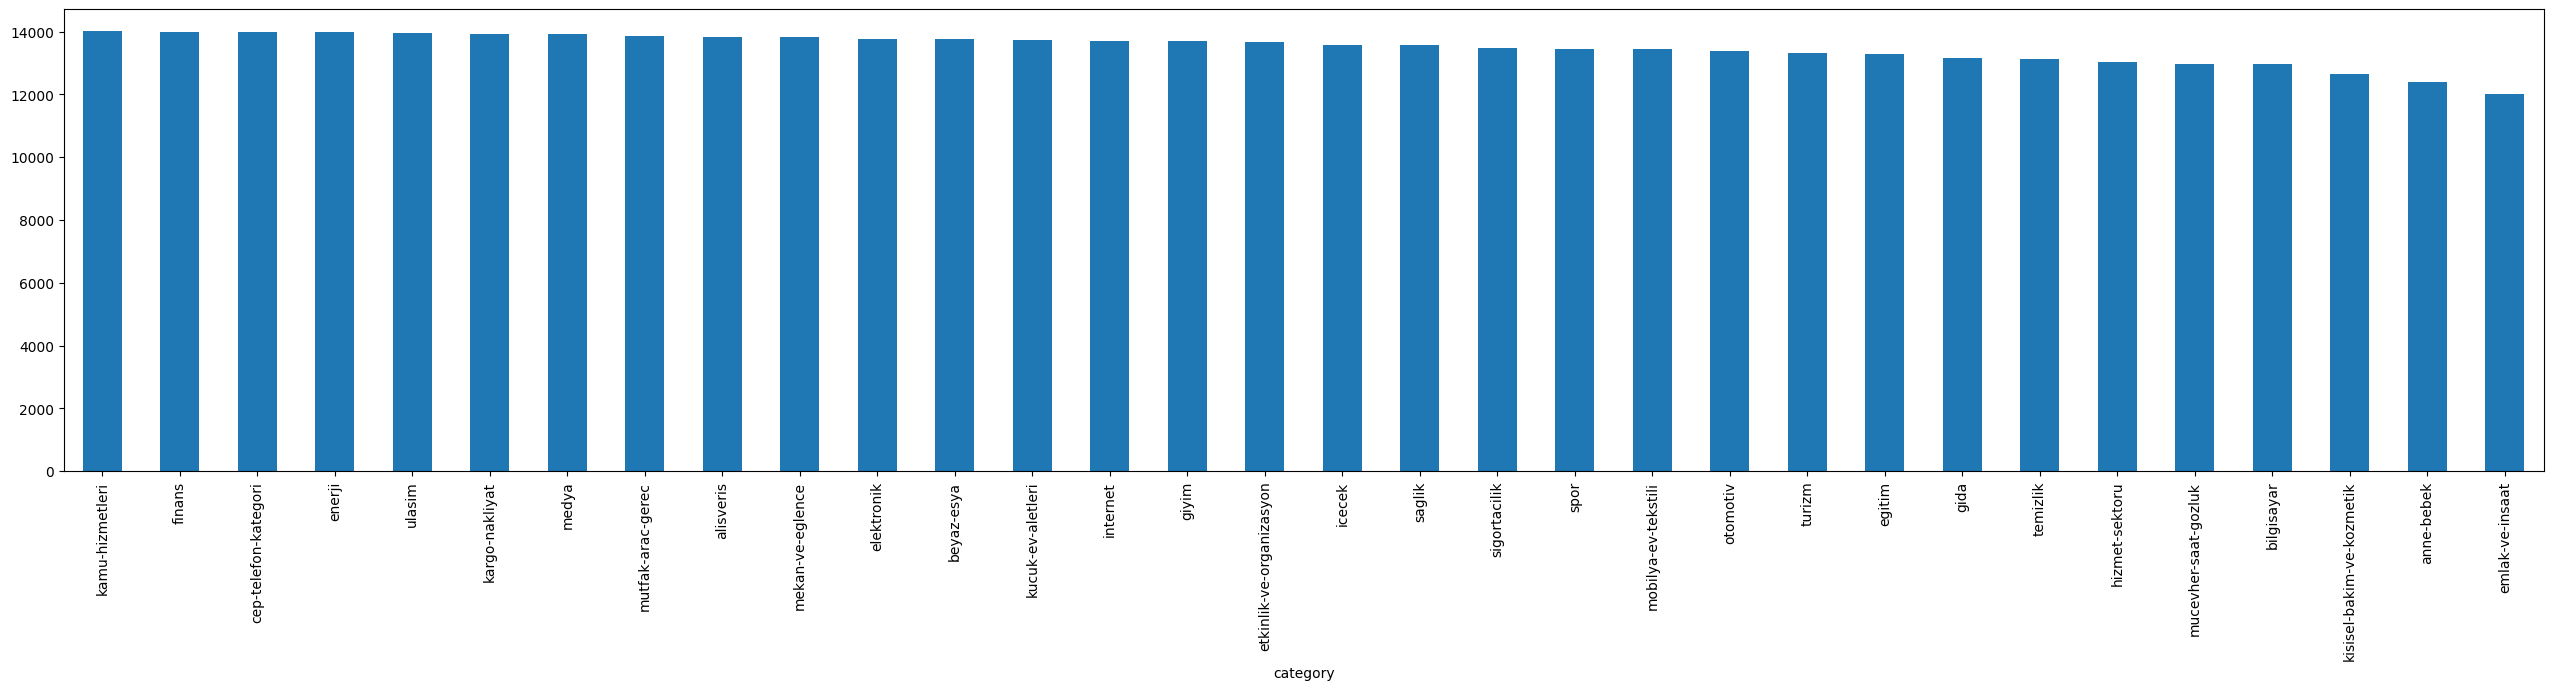

In [ ]:
data.category.value_counts().plot.bar(x="Topics",y="Number of Reviews",figsize=(32,6) )

**Yorumların** **analizi**

In [ ]:
data.head(5)

,category,text
0,alisveris,Altus Hırdavat Yapı Malzemeleri Drone Diye Kar...
1,alisveris,"Albay Bilgisayar Garanti Yalanı İle Yanılttı,G..."
2,alisveris,"Okyanus Petshop Ürün İade Sorunu!,Satıcıdan Gi..."
3,alisveris,Anda İhtiyaç Ve Tüketim Maddeleri Knee Tork Di...
4,alisveris,BB Kargo Dağıtım'dan Aldığım Ürün Bozuk Çıktı ...


**Yorumlardaki kelime sayılarını belirleme ve belirlenen aralığı seçme**

In [ ]:
data['words'] = [len(x.split()) for x in data['text'].tolist()]

In [ ]:
data[['words','text']].head()

,words,text
0,49,Altus Hırdavat Yapı Malzemeleri Drone Diye Kar...
1,44,"Albay Bilgisayar Garanti Yalanı İle Yanılttı,G..."
2,47,"Okyanus Petshop Ürün İade Sorunu!,Satıcıdan Gi..."
3,53,Anda İhtiyaç Ve Tüketim Maddeleri Knee Tork Di...
4,48,BB Kargo Dağıtım'dan Aldığım Ürün Bozuk Çıktı ...


In [ ]:
data['words'].describe()

count    431306.000000
mean         44.424654
std           8.101678
min           2.000000
25%          42.000000
50%          46.000000
75%          49.000000
max         183.000000
Name: words, dtype: float64

In [ ]:
data.groupby(['category'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
alisveris,13835.0,43.565811,8.603850,4.0,41.0,45.0,49.0,63.0
anne-bebek,12382.0,44.833549,7.237956,3.0,42.0,46.0,49.0,62.0
beyaz-esya,13763.0,45.227203,7.409006,4.0,43.0,47.0,50.0,67.0
bilgisayar,12964.0,44.252700,8.119242,3.0,42.0,46.0,49.0,95.0
cep-telefon-kategori,13981.0,43.846506,8.072643,5.0,41.0,45.0,49.0,64.0
egitim,13269.0,43.345241,7.984532,4.0,41.0,45.0,48.0,68.0
elektronik,13772.0,44.028827,8.271971,3.0,41.0,46.0,49.0,64.0
emlak-ve-insaat,12024.0,44.880073,8.079509,3.0,42.0,47.0,50.0,66.0
enerji,13979.0,44.905930,8.637976,4.0,42.0,46.0,50.0,183.0


In [ ]:
min_review_size = 15
data[data['words']<min_review_size].count()

category    4957
text        4957
words       4957
dtype: int64

In [ ]:
data[data['words']<min_review_size]

,category,text,words
143,alisveris,Vatan Bilgisayar Kargo Hakkında Bilgi Verilmem...,13
146,alisveris,"A101 Sipariş Alıyor Ancak Getirmiyor,""28.05.20...",8
198,alisveris,"Boyner Eksik Ürün Gönderme,""Merhabalar",4
206,alisveris,"Tekzen 40 Gündür Ücret İadesi Yapılmıyor,""17.0...",14
228,alisveris,"Boyner Sipariş 1 Haftadır Tedarik Sürecinde!,""...",6
...,...,...,...
430835,ulasim,"Pegasus Uçuşu İptal Etti!,""13.02.2020 diyarbak...",12
430854,ulasim,Kent Kart'a FastPay İle Yaptığım Yükleme Hesab...,13
430997,ulasim,"Efe Tur İnternet Yok,""İnternet şifresi istiyor...",12
431095,ulasim,"Efe Tur'da Saygısızlık, İhmalkarlık!,""11.02.20...",13


In [ ]:
min_review_size = 15
max_review_size = 40 #50

In [ ]:
data.count()

category    431306
text        431306
words       431306
dtype: int64

In [ ]:
data= data[data['words']>=min_review_size]

In [ ]:
data.count()

category    426349
text        426349
words       426349
dtype: int64

In [ ]:
data[data['words']<min_review_size].count()

category    0
text        0
words       0
dtype: int64

**Sözlük oluşturma**

In [ ]:
vocab = set()
corpus= [x.split() for x in data['category'].tolist()]
for sentence in corpus:
  for word in sentence:
    vocab.add(word.lower())
print("Number of distinct words in raw data: ", len(vocab))

Number of distinct words in raw data:  32


In [ ]:
list(vocab)[:25]

['gida',
 'kucuk-ev-aletleri',
 'elektronik',
 'finans',
 'spor',
 'mekan-ve-eglence',
 'icecek',
 'mutfak-arac-gerec',
 'medya',
 'hizmet-sektoru',
 'bilgisayar',
 'internet',
 'temizlik',
 'egitim',
 'emlak-ve-insaat',
 'turizm',
 'kisisel-bakim-ve-kozmetik',
 'enerji',
 'cep-telefon-kategori',
 'kargo-nakliyat',
 'sigortacilik',
 'anne-bebek',
 'kamu-hizmetleri',
 'etkinlik-ve-organizasyon',
 'mobilya-ev-tekstili']

In [ ]:
word_freq= data.text.str.split(expand=True).stack().value_counts()
word_freq=word_freq.reset_index(name='freq').rename(columns={'index': 'word'})

In [ ]:
top_50_frequent_words = word_freq[:50]
top_50_frequent_words

,word,freq
0,bir,292157
1,oku,269502
2,ve,255902
3,için,134409
4,bu,122169
5,"oku""",116855
6,de,101563
7,da,83412
8,ama,70404
9,ile,68176


In [ ]:
for each in top_50_frequent_words['word']:
  if each in tr_stop_words.values:
    print (each)


bir
ve
için
bu
de
da
ama
ile
sonra
rağmen
önce
çok
kadar
daha
diye
gibi
yok
fakat
bana


In [ ]:
data["category"]

0         alisveris
1         alisveris
2         alisveris
3         alisveris
4         alisveris
            ...    
431301       ulasim
431302       ulasim
431303       ulasim
431304       ulasim
431305       ulasim
Name: category, Length: 426349, dtype: object

In [ ]:
data["category"] = data["category"].astype('category')
data.dtypes

category    category
text          object
words          int64
dtype: object

In [ ]:
data["category_id"] = data["category"].cat.codes
data.tail()

,category,text,words,category_id
431301,ulasim,Pegasus Kabin Boyu Bagajım İçin 20 Euro Aldıla...,50,31
431302,ulasim,"Pegasus Sefer Saat Değişikliği,""05.02.2020 tar...",40,31
431303,ulasim,"THY Saygısız Müşteri Temsilcisi!,""THY'den bile...",26,31
431304,ulasim,"KLM Havayolları Bilgisizlikleri,Kraliyet firma...",50,31
431305,ulasim,"Pegasus Çağrı Merkezi,""Pegasus internet sayfas...",51,31


In [ ]:
data.dtypes

category       category
text             object
words             int64
category_id        int8
dtype: object

**Sözlük Oluşturma id to text category**

In [ ]:
id_to_category = pd.Series(data.category.values,index=data.category_id).to_dict()
id_to_category

{0: 'alisveris',
 1: 'anne-bebek',
 2: 'beyaz-esya',
 3: 'bilgisayar',
 4: 'cep-telefon-kategori',
 5: 'egitim',
 6: 'elektronik',
 7: 'emlak-ve-insaat',
 8: 'enerji',
 9: 'etkinlik-ve-organizasyon',
 10: 'finans',
 11: 'gida',
 12: 'giyim',
 13: 'hizmet-sektoru',
 14: 'icecek',
 15: 'internet',
 16: 'kamu-hizmetleri',
 17: 'kargo-nakliyat',
 18: 'kisisel-bakim-ve-kozmetik',
 19: 'kucuk-ev-aletleri',
 20: 'medya',
 21: 'mekan-ve-eglence',
 22: 'mobilya-ev-tekstili',
 23: 'mucevher-saat-gozluk',
 24: 'mutfak-arac-gerec',
 25: 'otomotiv',
 26: 'saglik',
 27: 'sigortacilik',
 28: 'spor',
 29: 'temizlik',
 30: 'turizm',
 31: 'ulasim'}

 **Category (topic) için başka bir Sözlük Oluşturma**

In [ ]:
category_to_id= {v:k for k,v in id_to_category.items()}
category_to_id

{'alisveris': 0,
 'anne-bebek': 1,
 'beyaz-esya': 2,
 'bilgisayar': 3,
 'cep-telefon-kategori': 4,
 'egitim': 5,
 'elektronik': 6,
 'emlak-ve-insaat': 7,
 'enerji': 8,
 'etkinlik-ve-organizasyon': 9,
 'finans': 10,
 'gida': 11,
 'giyim': 12,
 'hizmet-sektoru': 13,
 'icecek': 14,
 'internet': 15,
 'kamu-hizmetleri': 16,
 'kargo-nakliyat': 17,
 'kisisel-bakim-ve-kozmetik': 18,
 'kucuk-ev-aletleri': 19,
 'medya': 20,
 'mekan-ve-eglence': 21,
 'mobilya-ev-tekstili': 22,
 'mucevher-saat-gozluk': 23,
 'mutfak-arac-gerec': 24,
 'otomotiv': 25,
 'saglik': 26,
 'sigortacilik': 27,
 'spor': 28,
 'temizlik': 29,
 'turizm': 30,
 'ulasim': 31}

In [ ]:
print("alisveris id is " , category_to_id["alisveris"])
print("0 is for " , id_to_category[0])

alisveris id is  0
0 is for  alisveris


In [ ]:
import pickle
with open('category_to_id.pkl', 'wb') as fp:
    pickle.dump(category_to_id, fp)

In [ ]:
!ls

In [ ]:
import pickle
with open('id_to_category.pkl', 'wb') as fp:
    pickle.dump(id_to_category, fp)

In [ ]:
id_to_category

{0: 'alisveris',
 1: 'anne-bebek',
 2: 'beyaz-esya',
 3: 'bilgisayar',
 4: 'cep-telefon-kategori',
 5: 'egitim',
 6: 'elektronik',
 7: 'emlak-ve-insaat',
 8: 'enerji',
 9: 'etkinlik-ve-organizasyon',
 10: 'finans',
 11: 'gida',
 12: 'giyim',
 13: 'hizmet-sektoru',
 14: 'icecek',
 15: 'internet',
 16: 'kamu-hizmetleri',
 17: 'kargo-nakliyat',
 18: 'kisisel-bakim-ve-kozmetik',
 19: 'kucuk-ev-aletleri',
 20: 'medya',
 21: 'mekan-ve-eglence',
 22: 'mobilya-ev-tekstili',
 23: 'mucevher-saat-gozluk',
 24: 'mutfak-arac-gerec',
 25: 'otomotiv',
 26: 'saglik',
 27: 'sigortacilik',
 28: 'spor',
 29: 'temizlik',
 30: 'turizm',
 31: 'ulasim'}

In [ ]:
!ls

 cars.xls				  function_calling-failed.ipynb   Reviews.csv
 category_to_id.pkl			  id_to_category.pkl		  ticaret-yorum.csv
'Cok Sinifli Metin Siniflandirma.ipynb'   preprocessed_data.csv		  tr_stop_word.txt


In [ ]:
# Open the file for reading
with open('id_to_category.pkl', 'rb') as fp:
    id_to_category_loaded = pickle.load(fp)

In [ ]:
id_to_category_loaded

{0: 'alisveris',
 1: 'anne-bebek',
 2: 'beyaz-esya',
 3: 'bilgisayar',
 4: 'cep-telefon-kategori',
 5: 'egitim',
 6: 'elektronik',
 7: 'emlak-ve-insaat',
 8: 'enerji',
 9: 'etkinlik-ve-organizasyon',
 10: 'finans',
 11: 'gida',
 12: 'giyim',
 13: 'hizmet-sektoru',
 14: 'icecek',
 15: 'internet',
 16: 'kamu-hizmetleri',
 17: 'kargo-nakliyat',
 18: 'kisisel-bakim-ve-kozmetik',
 19: 'kucuk-ev-aletleri',
 20: 'medya',
 21: 'mekan-ve-eglence',
 22: 'mobilya-ev-tekstili',
 23: 'mucevher-saat-gozluk',
 24: 'mutfak-arac-gerec',
 25: 'otomotiv',
 26: 'saglik',
 27: 'sigortacilik',
 28: 'spor',
 29: 'temizlik',
 30: 'turizm',
 31: 'ulasim'}

**kategori sayısını kontrol etme**

In [ ]:
number_of_categories = len(category_to_id)
print("number_of_categories: ",number_of_categories)

number_of_categories:  32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426349 entries, 0 to 431305
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   category     426349 non-null  category
 1   text         426349 non-null  object  
 2   words        426349 non-null  int64   
 3   category_id  426349 non-null  int8    
dtypes: category(1), int64(1), int8(1), object(1)
memory usage: 26.7+ MB


In [ ]:
#limit the number of samples to be used in code runs
#Total Number of Reviews is 427230
data_size=  427230
data= data[:data_size]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426349 entries, 0 to 431305
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   category     426349 non-null  category
 1   text         426349 non-null  object  
 2   words        426349 non-null  int64   
 3   category_id  426349 non-null  int8    
dtypes: category(1), int64(1), int8(1), object(1)
memory usage: 10.6+ MB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426349 entries, 0 to 431305
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   category     426349 non-null  category
 1   text         426349 non-null  object  
 2   words        426349 non-null  int64   
 3   category_id  426349 non-null  int8    
dtypes: category(1), int64(1), int8(1), object(1)
memory usage: 10.6+ MB


**Ham veriyi Train, Validation, and Test verisetlerine bölme**

In [ ]:
# save features and targets from the 'data'
features, targets = data['text'], data['category_id']

all_train_features, test_features, all_train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        random_state=42,
        shuffle = True,
        stratify=targets
    )

In [ ]:
print("All Train Data Set size: ",len(all_train_features))
print("Test Data Set size: ",len(test_features))

All Train Data Set size:  341079
Test Data Set size:  85270


In [ ]:
reduce_ratio = 0.05

reduced_train_features, _, reduced_train_targets, _ = train_test_split(
        all_train_features, all_train_targets,
        train_size=reduce_ratio,
        random_state=42,
        shuffle = True,
        stratify=all_train_targets
    )

In [ ]:
print("Reduced Train Data Set size: ",len(reduced_train_features))
print("Test Data Set size: ",len(test_features))

Reduced Train Data Set size:  17053
Test Data Set size:  85270


In [ ]:
train_features, val_features, train_targets, val_targets = train_test_split(
        reduced_train_features, reduced_train_targets,
        train_size=0.9,
        random_state=42,
        shuffle = True,
        stratify=reduced_train_targets
    )

In [ ]:
print("Train Data Set size: ",len(train_features))
print("Validation Data Set size: ",len(val_features))
print("Test Data Set size: ",len(test_features))

Train Data Set size:  15347
Validation Data Set size:  1706
Test Data Set size:  85270


**Train TensorFlow Datasets build etme (bölüm4)**

In [ ]:
train_features.values[:5]

array(["Arçelik TV Netflix Uygulamasının Olmaması,9bin tl'ye aldığımız televizyonda Netflix uygulaması yok ve hiçbir şekilde yüklenemiyor. Telefondan bağlanamıyor. Bir güncelleme yapılsın Netflix yüklensin. Lütfen çok pahalıya aldığımız için tekrar yenisini alamıyoruz 1 sene oldu yaklaşık olarak alalı o yüzden değişimde yapılamıyor.Devamını oku",
       'Yazilimbudur.com Lisansı Göndermedi,İki gün önce bir lisans aldım. EFT yöntemiyle ücret ödemesi yaptım. Lisans bir türlü gönderilmedi ve para iadesi de yapılmıyor. Sipariş numarası veremedikleri halde sipariş numarası istiyorlar. Ben bu şirketin art niyetli olduğunu düşünmeye başladım.Devamını oku',
       'Cinemaximum Ve Sinemia Haksızlığı!,"[xxx] PNR numarası ile Sinemia’dan aldığım biletimi Cinemaximum web sitesinden satın alamıyorum, hata veriyor. Bir de güya Premium üyeliğim var Sinemia’dan. Hiçbir destek hizmeti sunmuyor. İşlemlerimizi web sitelerinden halledebilirmişiz. Muhatap ararsanız yok. Hayır iş birliği yapıyor musunuz? Yo

In [ ]:
train_targets.values[:5]

array([ 6,  3,  9, 17, 30], dtype=int8)

In [ ]:
# this is the input (text/reviews) dataset
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_features.values, tf.string)
)

In [ ]:
# this is the target (categories/topics) dataset
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_targets.values, tf.int64),

)

In [ ]:
vocab_size = 100000  # Only consider the top 100K words
max_len = max_review_size  # Max review size in words

**Veriyi standart hale getirme**

In [ ]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    no_uppercased = tf.strings.lower(input_string, encoding='utf-8')
    no_stars = tf.strings.regex_replace(no_uppercased, "\*", " ")
    no_repeats = tf.strings.regex_replace(no_stars, "devamını oku", "")
    no_html = tf.strings.regex_replace(no_repeats, "<br />", "")
    no_digits = tf.strings.regex_replace(no_html, "\w*\d\w*","")
    no_punctuations = tf.strings.regex_replace(no_digits, f"([{string.punctuation}])", r" ")
    #remove stop words
    #no_stop_words = ' '+no_punctuations+ ' '
    #for each in tr_stop_words.values:
    #  no_stop_words = tf.strings.regex_replace(no_stop_words, ' '+each[0]+' ' , r" ")
    no_extra_space = tf.strings.regex_replace(no_punctuations, " +"," ")
    #remove Turkish chars
    no_I = tf.strings.regex_replace(no_extra_space, "ı","i")
    no_O = tf.strings.regex_replace(no_I, "ö","o")
    no_C = tf.strings.regex_replace(no_O, "ç","c")
    no_S = tf.strings.regex_replace(no_C, "ş","s")
    no_G = tf.strings.regex_replace(no_S, "ğ","g")
    no_U = tf.strings.regex_replace(no_G, "ü","u")
    return no_U

In [ ]:
input_string = data
print("input:  ", data)
output_string= custom_standardization(input_string)
print("output: ", output_string.numpy())

**Vektörizasyon katmanı oluşturma**

In [ ]:
# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int", #tf-idf / int / binary / count
    output_sequence_length=max_len,
)

In [ ]:
vectorize_layer.adapt(train_text_ds_raw)
vocab = vectorize_layer.get_vocabulary()
# To get words back from token indices

**Bakalım çalışıyor mu**

In [ ]:
print("vocab has the ", len(vocab)," entries")
print("vocab has the following first 10 entries")
for word in range(10):
  print(word, " represents the word: ", vocab[word])
print("2 sample text preprocessing:")
for X in train_text_ds_raw.take(2):
  print(" Given raw data: " )
  print(X.numpy().decode("utf-8") )
  tokenized = vectorize_layer(tf.expand_dims(X, -1))
  print(" Tokenized and Transformed to a vector of integers: " )
  print (tokenized)
  print(" Text after Tokenized and Transformed: ")
  transformed = ""
  for each in tf.squeeze(tokenized):
    transformed= transformed+ " "+ vocab[each]
  print(transformed)

vocab has the  59506  entries
vocab has the following first 10 entries
0  represents the word:  
1  represents the word:  [UNK]
2  represents the word:  bir
3  represents the word:  ve
4  represents the word:  bu
5  represents the word:  icin
6  represents the word:  de
7  represents the word:  da
8  represents the word:  ama
9  represents the word:  yok
2 sample text preprocessing:
 Given raw data: 
Arçelik TV Netflix Uygulamasının Olmaması,9bin tl'ye aldığımız televizyonda Netflix uygulaması yok ve hiçbir şekilde yüklenemiyor. Telefondan bağlanamıyor. Bir güncelleme yapılsın Netflix yüklensin. Lütfen çok pahalıya aldığımız için tekrar yenisini alamıyoruz 1 sene oldu yaklaşık olarak alalı o yüzden değişimde yapılamıyor.Devamını oku
 Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[  235    71   526  8246  1709    10   183   232  3426   526  1346     9
      3    40    50 13121  1589 19623     2   809  2700   526 29595   113
     16  7667   232     5    85  2020  1723  

In [ ]:

%ls

In [ ]:
# Create a model to embed the trained TextVectorization layer
vectorizer_model = tf.keras.models.Sequential()
vectorizer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorizer_model.add(vectorize_layer)
vectorizer_model.summary()

# Save it
filepath = "vectorize_layer_model"
vectorizer_model.save(filepath, save_format="tf")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%ls

In [ ]:
# Load the saved model
loaded_vectorizer_model = tf.keras.models.load_model(filepath)
# Extract the trained TextVectorization layer out of the loaded model
loaded_vectorizer_layer = loaded_vectorizer_model.layers[0]

In [ ]:
loaded_vocab = loaded_vectorizer_layer.get_vocabulary()
print("original vocab has the ", len(vocab)," entries")
print("loaded_vectorizer_layer vocab has the ", len(loaded_vocab)," entries")
print("original vocab: ", vocab[:10])
print("loaded vocab  : ", loaded_vocab[:10])

original vocab has the  59506  entries
loaded_vectorizer_layer vocab has the  59506  entries
original vocab:  ['', '[UNK]', 'bir', 've', 'bu', 'icin', 'de', 'da', 'ama', 'yok']
loaded vocab  :  ['', '[UNK]', 'bir', 've', 'bu', 'icin', 'de', 'da', 'ama', 'yok']


In [ ]:
for X in train_text_ds_raw.take(1):
  print(" Given raw data: " )
  print(X.numpy().decode("utf-8") )

  tokenized = vectorize_layer(tf.expand_dims(X, -1))
  print(" original vectorizer layer: Tokenized and Transformed to a vector of integers: " )
  print (tokenized)

  tokenized = loaded_vectorizer_layer(tf.expand_dims(X, -1))
  print(" loaded_vectorizer_layer: Tokenized and Transformed to a vector of integers: " )
  #print (tokenized.to_tensor(shape=[1, max_review_size]))
  print (tokenized)

  tokenized = loaded_vectorizer_model.predict(tf.expand_dims(X, -1))
  print(" loaded_vectorizer_model: Tokenized and Transformed to a vector of integers: " )
  #print (tokenized.to_tensor(shape=[1, max_review_size]))
  print (tokenized)

  print(" Text after Tokenized and Transformed: ")
  transformed = ""
  for each in tf.squeeze(tokenized):
    transformed= transformed+ " "+ vocab[each]
  print(transformed)

 Given raw data: 
Arçelik TV Netflix Uygulamasının Olmaması,9bin tl'ye aldığımız televizyonda Netflix uygulaması yok ve hiçbir şekilde yüklenemiyor. Telefondan bağlanamıyor. Bir güncelleme yapılsın Netflix yüklensin. Lütfen çok pahalıya aldığımız için tekrar yenisini alamıyoruz 1 sene oldu yaklaşık olarak alalı o yüzden değişimde yapılamıyor.Devamını oku
 original vectorizer layer: Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[  235    71   526  8246  1709    10   183   232  3426   526  1346     9
      3    40    50 13121  1589 19623     2   809  2700   526 29595   113
     16  7667   232     5    85  2020  1723   318    43   110    39   668
     55   777 15135  3521]], shape=(1, 40), dtype=int64)
 loaded_vectorizer_layer: Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[  235    71   526  8246  1709    10   183   232  3426   526  1346     9
      3    40    50 13121  1589 19623     2   809  2700   526 29595   113
     16  7667   232     5    85  202

In [ ]:
def prepare_lm_inputs_labels(text):
    text = tf.expand_dims(text, -1)
    return tf.squeeze(vectorize_layer(text))
    #return tf.squeeze(loaded_vectorizer_layer(text).to_tensor(shape=[1, max_review_size]))

In [ ]:
train_text_ds = train_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
train_text_ds.element_spec

TensorSpec(shape=<unknown>, dtype=tf.int64, name=None)

In [ ]:
for each in train_text_ds.take(1):
  print(each)

tf.Tensor(
[  235    71   526  8246  1709    10   183   232  3426   526  1346     9
     3    40    50 13121  1589 19623     2   809  2700   526 29595   113
    16  7667   232     5    85  2020  1723   318    43   110    39   668
    55   777 15135  3521], shape=(40,), dtype=int64)


In [ ]:
train_ds = tf.data.Dataset.zip(
    (       train_text_ds,
            train_cat_ds_raw
        )
)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for X,y in train_ds.take(1):
  print("X.shape: ",X.shape, "y.shape: ", y.shape)
  print("X: ", X)
  print("y: ", y)
  input = " ".join([vocab[_] for _ in np.squeeze(X)])
  output = id_to_category[y.numpy()]
  print("input (review as text): " , input)
  print("output (category as text): " , output)

X.shape:  (40,) y.shape:  ()
X:  tf.Tensor(
[  235    71   526  8246  1709    10   183   232  3426   526  1346     9
     3    40    50 13121  1589 19623     2   809  2700   526 29595   113
    16  7667   232     5    85  2020  1723   318    43   110    39   668
    55   777 15135  3521], shape=(40,), dtype=int64)
y:  tf.Tensor(6, shape=(), dtype=int64)
input (review as text):  arcelik tv netflix uygulamasinin olmamasi tl ye aldigimiz televizyonda netflix uygulamasi yok ve hicbir sekilde yuklenemiyor telefondan baglanamiyor bir guncelleme yapilsin netflix yuklensin lutfen cok pahaliya aldigimiz icin tekrar yenisini alamiyoruz sene oldu yaklasik olarak alali o yuzden degisimde yapilamiyor
output (category as text):  elektronik


In [ ]:
# train dataset size
train_size = train_ds.cardinality().numpy()
print("Train size: ", train_size)

Train size:  15347


**Validasyon verisini işleme**

In [ ]:
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(val_features.values, tf.string)
)

In [ ]:
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(val_targets.values, tf.int64),

)

In [ ]:
val_text_ds = val_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
val_ds = tf.data.Dataset.zip(
    (       val_text_ds,
            val_cat_ds_raw
       )
)

In [ ]:
for X,y in val_ds.take(1):
  print("X.shape: ",X.shape, "y.shape: ", y.shape)
  print("X: ", X)
  print("y: ",y)
  input = " ".join([vocab[_] for _ in np.squeeze(X)])
  output = id_to_category[y.numpy()]
  print("input (review as text): " , input)
  print("output (category as text ): " , output)

X.shape:  (40,) y.shape:  ()
X:  tf.Tensor(
[ 7551  5227  1161   791    63   124   501    41     2   138   248  2328
   343 42458  5734   622    79  3206    12  1621  4488     1   158     7
  3434 49322     3    87  1431    85  5706   160  4488 27996   273   137
  1676  7541  1239     4], shape=(40,), dtype=int64)
y:  tf.Tensor(11, shape=(), dtype=int64)
input (review as text):  tugba kuruyemis ulasmak mumkun degil siparisim hatali geldi bir urunun buyuk boyu yerine kucugunu yollamislar telefonla aradim bekledikten sonra kapandi siradan [UNK] dakika da siraya geliyorsunuz ve telefon kapaniyor tekrar aradiginizda yine siradan baslatiyor bende mail yoluyla ulasmayi denedim bu
output (category as text ):  gida


**Test verisini işleme**

In [ ]:
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_features.values, tf.string)
)

In [ ]:
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_targets.values, tf.int64),

)

In [ ]:
test_text_ds = test_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
test_ds = tf.data.Dataset.zip(
    (       test_text_ds,
            test_cat_ds_raw
       )
)

In [ ]:
for X,y in test_ds.take(1):
  print("X.shape: ",X.shape, "y.shape: ", y.shape)
  print("X: ", X)
  print("y: ",y)
  input = " ".join([vocab[_] for _ in np.squeeze(X)])
  output = id_to_category[y.numpy()]
  print("input (review as text): " , input)
  print("output (category as text ): " , output)

X.shape:  (40,) y.shape:  ()
X:  tf.Tensor(
[  306  3792     1   401   757  2751   155  6904   197 27775  6144    16
    19    17   401    43   386     1  2341     2    50  4578   831     8
   306    53     2    14   315    19  1026     0     0     0     0     0
     0     0     0     0], shape=(40,), dtype=int64)
y:  tf.Tensor(15, shape=(), dtype=int64)
input (review as text):  trendyol alisveriste [UNK] sikinti yillardir internette alisveris yaparim diger bildik sitelerden cok urun aldim sikinti oldu mu [UNK] sorunsuz bir sekilde geriye alindi ama trendyol dan bir daha kesinlikle urun almam         
output (category as text ):  internet


In [ ]:
# test dataset size
test_size = test_ds.cardinality().numpy()
print("Test size: ", test_size)

Test size:  85270


**TensorFlow data pipeline**

In [ ]:
batch_size=64
AUTOTUNE=tf.data.experimental.AUTOTUNE

train_ds=train_ds.shuffle(buffer_size=train_size)
train_ds=train_ds.batch(batch_size=batch_size,drop_remainder=True)
train_ds=train_ds.cache()
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds=val_ds.shuffle(buffer_size=train_size)
val_ds=val_ds.batch(batch_size=batch_size,drop_remainder=True)
val_ds=val_ds.cache()
val_ds = val_ds.prefetch(AUTOTUNE)

test_ds=test_ds.shuffle(buffer_size=train_size)
test_ds=test_ds.batch(batch_size=batch_size,drop_remainder=True)
test_ds=test_ds.cache()
test_ds = test_ds.prefetch(AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

In [ ]:
desired_time_steps=64
desired_feature_dim= 40

def reshape_data(x, y):
    # Giriş verisi (x) boyutunu yeniden belirle
    x_reshaped = tf.reshape(x, (desired_time_steps, desired_feature_dim))
    return x_reshaped, y

# Boyutları yeniden belirlemek için reshape_data işlevini kullanarak train_ds'i dönüştür
train_ds = train_ds.map(reshape_data)
val_ds = val_ds.map(reshape_data)
test_ds = test_ds.map(reshape_data)

In [ ]:
val_ds.element_spec

(TensorSpec(shape=(64, 40), dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

In [ ]:
for X, y in val_ds.take(1):
  print(X.shape, y.shape)
  print("All categories values in this batch: ", y)
  print("\nFirst sample in the batch:")
  print("\tX is: " ,X[0])
  print("\ty is: ", y[0].numpy)
  input = " ".join([vocab[_] for _ in np.squeeze(X[0])])
  output = id_to_category[y[0].numpy()]
  print("\tinput (in text): " , input)
  print("\toutput (in category): " , output)

  print("\nSecond sample in the batch:")
  print("\tX is: " ,X[1])
  print("\ty is: ", y[1].numpy)
  input = " ".join([vocab[_] for _ in np.squeeze(X[1])])
  output = id_to_category[y[1].numpy()]
  print("\tinput (in text): " , input)
  print("\toutput (in category): " , output)

(64, 40) (64,)
All categories values in this batch:  tf.Tensor(
[13 26 13 11 18  4 25 22  0 10 20  6 19  3 19 14 20 19 20 18  6  9 17 13
  4 22  1 16 29  7  9  3 15  2 25 12 30 18 10 20 13 29 23  5  9 18 10 20
  7 20  8  8 19 30 17  0  3  5  7 13  2  7 29 23], shape=(64,), dtype=int64)

First sample in the batch:
	X is:  tf.Tensor(
[ 8740  1032  1686  3950  8776  4250  2910 16250   853  2071   356   513
  1697   756  3895  7988     2  1015  7416  1315  5216    15  5845   389
  1315 17397 16590  2437    64  2371  7416  1105  1032  3710   613   646
   191 19638 17398 18080], shape=(40,), dtype=int64)
	y is:  <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=int64, numpy=13>>
	input (in text):  doruk guvenlik personeli uygunsuz davrandi besiktas ilcesinde ucaksavar sitesinde kaliyorum dun gece dort arkadas evimize donerken bir kadin arkadasimiz siteye marti ile onden gitti siteye martinin sokulmasinin yasak oldugunu bilmeyen arkadasimiz sitede guvenlik mudurlugu yapan m 

In [ ]:
train_ds.save("../input/savedData/train_ds")
val_ds.save("../input/savedData/val_ds")
test_ds.save("../input/savedData/test_ds")

In [ ]:
loaded_train_ds = tf.data.Dataset.load("../input/savedData/train_ds")

In [ ]:
for X, y in train_ds.take(1):
  print(X.shape, y.shape)
  print("All categories values in this batch: ", y)
  print("\nFirst sample in the batch:")
  print("\tX is: " ,X[0])
  print("\ty is: ", y[0].numpy)
  input = " ".join([vocab[_] for _ in np.squeeze(X[0])])
  output = id_to_category[y[0].numpy()]
  print("\tinput (in text): " , input)
  print("\toutput (in category): " , output)

  print("\nSecond sample in the batch:")
  print("\tX is: " ,X[1])
  print("\ty is: ", y[1].numpy)
  input = " ".join([vocab[_] for _ in np.squeeze(X[1])])
  output = id_to_category[y[1].numpy()]
  print("\tinput (in text): " , input)
  print("\toutput (in category): " , output)

(64, 40) (64,)
All categories values in this batch:  tf.Tensor(
[ 6 17  8 12  1  3 18  5 12 20 20 16  9 17 16 23  2 15 23 15  8  1  6 31
 27 17 14 22 17  4  0 27 25 23  4 30  2 24 18 25 11  7 27 27  9 16 16 21
 21 20 22  0 31 29  8 20 19 28 14 29 28 30  2 29], shape=(64,), dtype=int64)

First sample in the batch:
	X is:  tf.Tensor(
[24332   178   321     9 24332    66   261 23303  2958    17  9730   422
   403   179  8697    18   178   171   345  2806   483 27945  1201   134
  6664   912  1491  2449   283   234   441  2493   380  1119     0     0
     0     0     0     0], shape=(40,), dtype=int64)
	y is:  <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=int64, numpy=6>>
	input (in text):  kawai yetkili servisi yok kawai marka model multimedya teyp aldim dokunmatigi calismiyor garantisi devam etmesine ragmen yetkili servise ulasamiyorum telefonlar kapali bayilere sordugumda artik kapandigini soyluyorlar birakin tamiri teknik destek dahi alacak muhatap bulamiyorum    

**Bölüm 5 - Keras Embedding Katmanı ile Model Geliştirmek**

In [ ]:
# Embedding size for each token
embed_dim = 16
# Hidden layer size in feed forward network
feed_forward_dim = 64
def create_model_FFN():
    inputs_tokens = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_layer = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       input_length=max_len)
    x = embedding_layer(inputs_tokens)
    x = layers.Flatten()(x)
    dense_layer = layers.Dense(feed_forward_dim, activation='relu')
    x = dense_layer(x)
    x = layers.Dropout(.5)(x)
    outputs = layers.Dense(number_of_categories)(x)

    model = keras.Model(inputs=inputs_tokens, outputs=outputs, name='model_FFN')
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric_fn  = tf.keras.metrics.SparseCategoricalAccuracy()
    model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)
    return model

model_FFN=create_model_FFN()

In [ ]:
model_FFN.summary()

Model: "model_FFN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 16)            1600000   
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 64)                41024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
Total params: 1643104 (6.27 MB)
Trainable params: 1643104

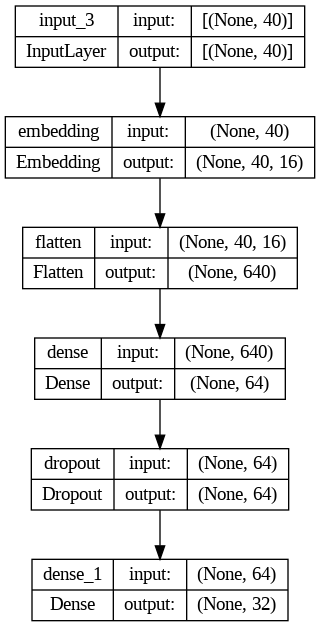

In [ ]:
tf.keras.utils.plot_model(model_FFN,show_shapes=True)

In [ ]:
history=model_FFN.fit(train_ds, validation_data=val_ds ,verbose=2, epochs=7)

Epoch 1/7
239/239 - 4s - loss: 3.3325 - sparse_categorical_accuracy: 0.1576 - val_loss: 2.8058 - val_sparse_categorical_accuracy: 0.4796 - 4s/epoch - 15ms/step
Epoch 2/7
239/239 - 2s - loss: 1.8205 - sparse_categorical_accuracy: 0.5875 - val_loss: 1.0722 - val_sparse_categorical_accuracy: 0.8161 - 2s/epoch - 9ms/step
Epoch 3/7
239/239 - 2s - loss: 0.7628 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.6458 - val_sparse_categorical_accuracy: 0.8696 - 2s/epoch - 9ms/step
Epoch 4/7
239/239 - 2s - loss: 0.3852 - sparse_categorical_accuracy: 0.9217 - val_loss: 0.5170 - val_sparse_categorical_accuracy: 0.8816 - 2s/epoch - 9ms/step
Epoch 5/7
239/239 - 3s - loss: 0.2145 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.4660 - val_sparse_categorical_accuracy: 0.8876 - 3s/epoch - 11ms/step
Epoch 6/7
239/239 - 2s - loss: 0.1321 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.4438 - val_sparse_categorical_accuracy: 0.8930 - 2s/epoch - 9ms/step
Epoch 7/7
239/239 - 2s - loss: 0.0966 - spar

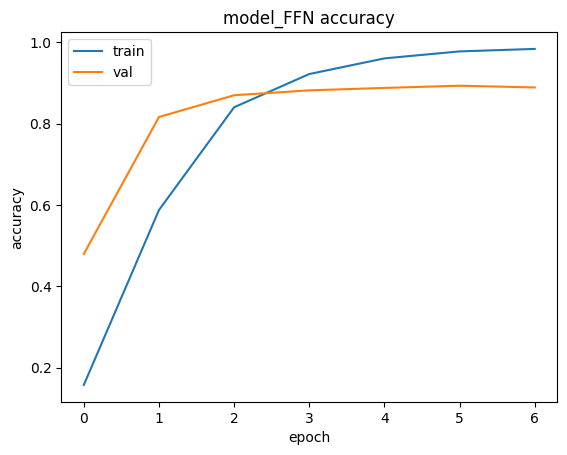

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model_FFN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

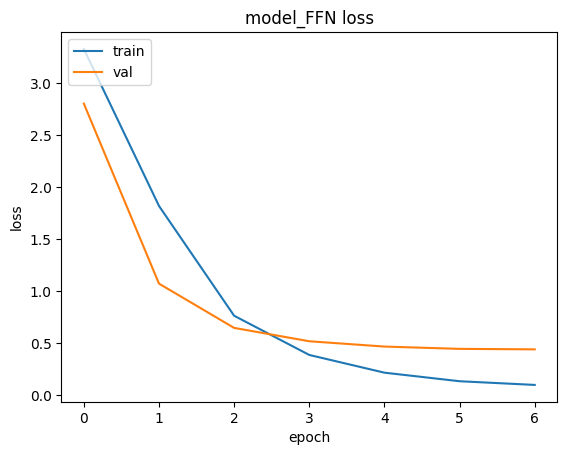

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_FFN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
tf.keras.models.save_model(model_FFN, 'MultiClassTextClassification_FFN')

**Test**

In [ ]:
loss, accuracy = model_FFN.evaluate(test_ds)
print("Test accuracy: ", accuracy)

1332/1332 [==============================] - 2s 1ms/step - loss: 0.4323 - sparse_categorical_accuracy: 0.8937
Test accuracy:  0.8937453031539917


**Tahmin**

In [ ]:
preds = model_FFN.predict(test_ds)
preds = preds.argmax(axis=1)

1332/1332 [==============================] - 3s 2ms/step


In [ ]:
actuals = test_ds.unbatch().map(lambda x,y: y)
actuals=list(actuals.as_numpy_iterator())

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8086    0.8128    0.8107      2713
           1     0.9455    0.9382    0.9418      2460
           2     0.8244    0.9038    0.8623      2733
           3     0.8409    0.8521    0.8465      2562
           4     0.9266    0.8798    0.9026      2770
           5     0.9730    0.8950    0.9324      2620
           6     0.8790    0.8665    0.8727      2726
           7     0.6514    0.7894    0.7138      2379
           8     0.9776    0.9630    0.9702      2759
           9     0.9800    0.8898    0.9327      2694
          10     0.9748    0.9329    0.9534      2742
          11     0.7866    0.8993    0.8392      2603
          12     0.9191    0.8996    0.9092      2689
          13     0.9167    0.8402    0.8768      2579
          14     0.9592    0.9467    0.9529      2683
          15     0.6622    0.7855    0.7186      2690
          16     0.9464    0.9177    0.9318      2771
          17     0.9787    

In [ ]:
from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,
# which compares the y_test and y_pred
cm = confusion_matrix(actuals, preds)
cm_df = pd.DataFrame(cm, index = id_to_category.values() ,columns = id_to_category.values())

In [ ]:
cm_df

,alisveris,anne-bebek,beyaz-esya,bilgisayar,cep-telefon-kategori,egitim,elektronik,emlak-ve-insaat,enerji,etkinlik-ve-organizasyon,...,mobilya-ev-tekstili,mucevher-saat-gozluk,mutfak-arac-gerec,otomotiv,saglik,sigortacilik,spor,temizlik,turizm,ulasim
alisveris,2205,16,3,28,6,1,14,28,0,0,...,15,7,1,28,6,1,0,20,1,1
anne-bebek,23,2308,0,10,0,0,0,5,0,0,...,1,3,2,3,1,0,3,7,0,0
beyaz-esya,9,0,2470,13,11,0,55,70,1,1,...,3,4,23,1,4,2,0,4,1,0
bilgisayar,18,3,24,2183,87,2,82,26,0,0,...,1,1,3,4,2,1,1,2,2,0
cep-telefon-kategori,3,0,33,72,2437,0,43,17,1,0,...,1,1,3,2,1,0,1,1,0,0
egitim,3,0,0,4,0,2345,0,52,0,3,...,8,1,1,4,22,1,8,0,20,2
elektronik,5,0,79,91,55,0,2362,35,3,0,...,1,1,4,2,0,0,0,0,1,0
emlak-ve-insaat,11,0,80,32,2,7,11,1878,25,5,...,7,2,6,58,5,2,4,25,9,3
enerji,0,0,1,16,0,4,1,36,2657,0,...,2,3,0,7,1,0,0,6,3,0
etkinlik-ve-organizasyon,4,1,1,0,0,7,9,96,2,2397,...,7,1,1,33,6,1,4,1,10,22


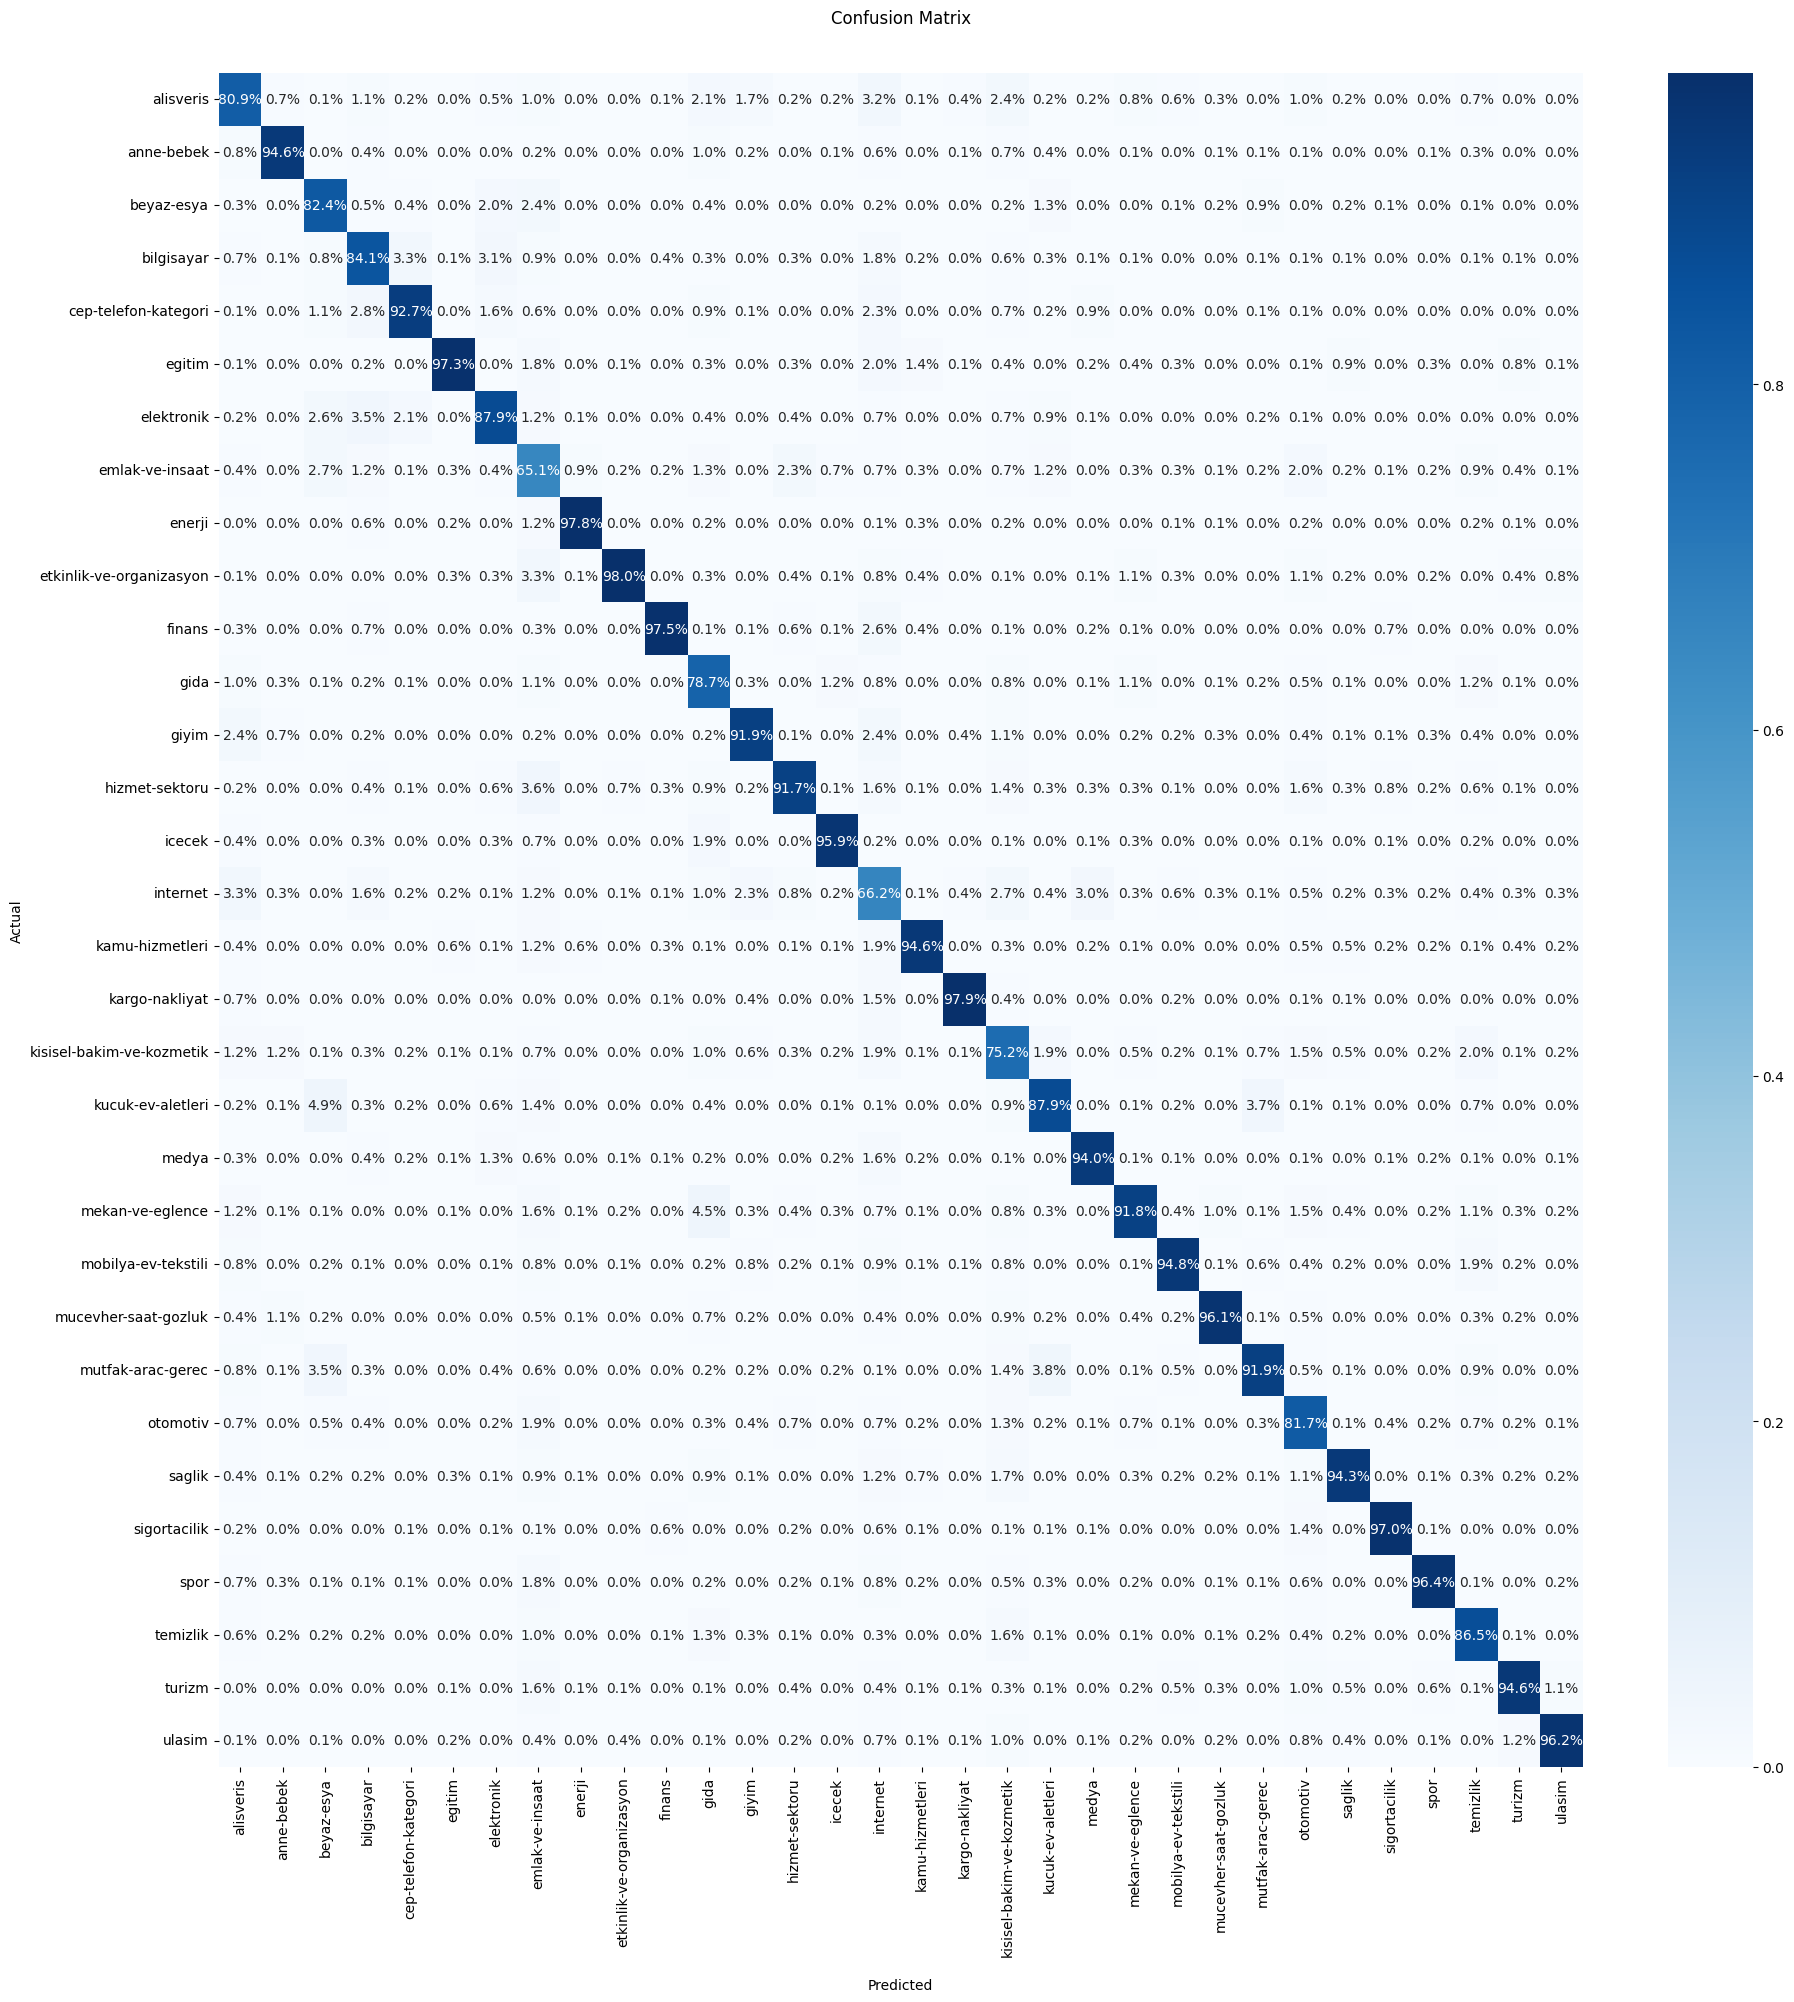

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(22,22))
ax = sns.heatmap(cm_df/np.sum(cm_df), annot=True, fmt='.1%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(id_to_category.values())
ax.yaxis.set_ticklabels(id_to_category.values())

## Display the visualization of the Confusion Matrix.
plt.show()

**Bölüm 6 Keras Conv1D Katmanı ile Model Geliştirmek**

In [ ]:
embed_dim = 16  # Embedding size for each token
feed_forward_dim = 64  # Hidden layer size in feed forward network

def create_model_Conv1D():
    inputs_tokens = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_layer = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       input_length=max_len)
    x = embedding_layer(inputs_tokens)
    x = layers.Conv1D(filters=256, kernel_size=7,
                      padding='same', activation='relu')(x)
    #x = layers.MaxPooling1D(pool_size=2)(x)
    #x = layers.Dropout(0.5)(x)
    x = layers.Conv1D(filters=128, kernel_size=5,
                      padding='same', activation='relu')(x)
    x = layers.Conv1D(filters=128, kernel_size=3,
                      padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    #x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(feed_forward_dim, activation='sigmoid')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(number_of_categories)(x)
    model = keras.Model(inputs=inputs_tokens,
                        outputs=outputs, name='model_Conv1D')
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric_fn  = tf.keras.metrics.SparseCategoricalAccuracy()
    model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)

    return model
model_Conv1D=create_model_Conv1D()

In [ ]:
model_Conv1D.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 40, 16)            1600000   
                                                                 
 conv1d (Conv1D)             (None, 40, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 128)           0         
 D)                                                              
                                                      

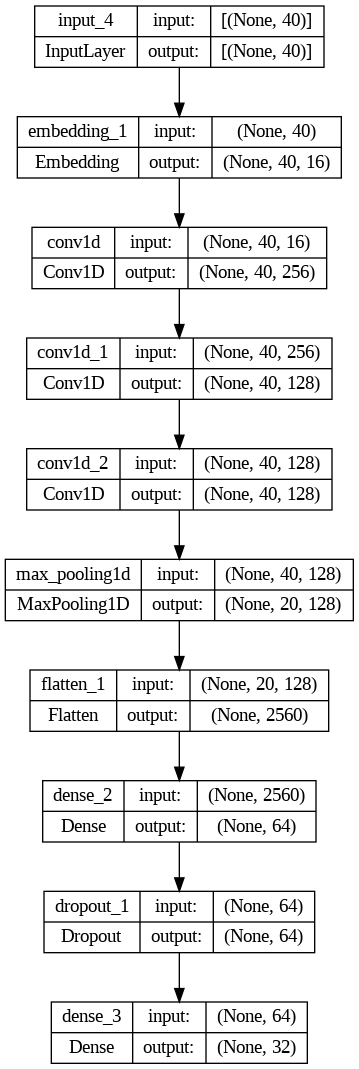

In [ ]:
tf.keras.utils.plot_model(model_Conv1D,show_shapes=True)

**Train**

In [ ]:
history=model_Conv1D.fit(train_ds, validation_data=val_ds ,verbose=1, epochs=25)

Epoch 1/25
239/239 [==============================] - 22s 89ms/step - loss: 3.4844 - sparse_categorical_accuracy: 0.0323 - val_loss: 3.4643 - val_sparse_categorical_accuracy: 0.0325
Epoch 2/25
239/239 [==============================] - 21s 88ms/step - loss: 3.2837 - sparse_categorical_accuracy: 0.0717 - val_loss: 2.9832 - val_sparse_categorical_accuracy: 0.1587
Epoch 3/25
239/239 [==============================] - 21s 87ms/step - loss: 2.7998 - sparse_categorical_accuracy: 0.1666 - val_loss: 2.5621 - val_sparse_categorical_accuracy: 0.2350
Epoch 4/25
239/239 [==============================] - 20s 85ms/step - loss: 2.2923 - sparse_categorical_accuracy: 0.2992 - val_loss: 2.1197 - val_sparse_categorical_accuracy: 0.4237
Epoch 5/25
239/239 [==============================] - 21s 89ms/step - loss: 1.9003 - sparse_categorical_accuracy: 0.4112 - val_loss: 1.8767 - val_sparse_categorical_accuracy: 0.4988
Epoch 6/25
239/239 [==============================] - 20s 85ms/step - loss: 1.6327 - spars

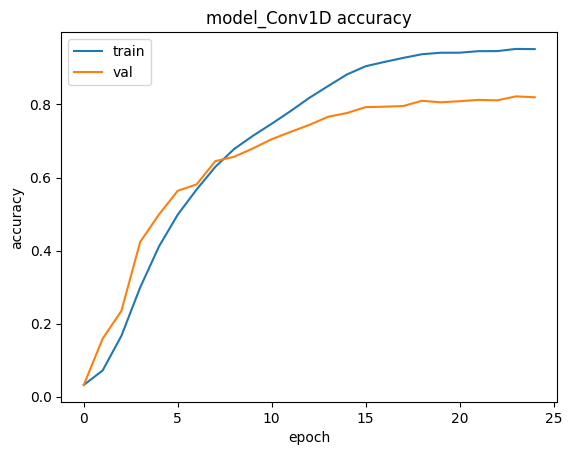

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model_Conv1D accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

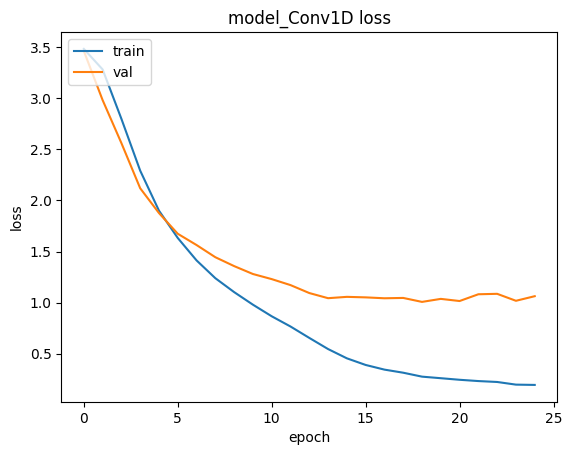

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_Conv1D loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
tf.keras.models.save_model(model_Conv1D, 'MultiClassTextClassification_Conv1D')

In [ ]:
model_Conv1D=tf.keras.models.load_model('MultiClassTextClassification_Conv1D')

In [ ]:
model_Conv1D.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 40, 16)            1600000   
                                                                 
 conv1d (Conv1D)             (None, 40, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 128)           0         
 D)                                                              
                                                      

**Test**

In [ ]:
loss, accuracy = model_Conv1D.evaluate(test_ds)
print("Test accuracy: ", accuracy)

1332/1332 [==============================] - 26s 19ms/step - loss: 1.0280 - sparse_categorical_accuracy: 0.8271
Test accuracy:  0.8271044492721558


**Tahmin**

In [ ]:
preds = model_Conv1D.predict(test_ds)
preds = preds.argmax(axis=1)

1332/1332 [==============================] - 25s 19ms/step


In [ ]:
actuals = test_ds.unbatch().map(lambda x,y: y)
actuals=list(actuals.as_numpy_iterator())

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8102    0.7553    0.7818      2713
           1     0.9650    0.8967    0.9296      2460
           2     0.7368    0.8390    0.7846      2733
           3     0.8380    0.6846    0.7536      2562
           4     0.9240    0.8300    0.8745      2770
           5     0.9704    0.8630    0.9135      2620
           6     0.7898    0.8613    0.8240      2726
           7     0.4209    0.4763    0.4469      2379
           8     0.9457    0.9344    0.9400      2759
           9     0.8467    0.8634    0.8550      2694
          10     0.7385    0.9216    0.8199      2742
          11     0.8527    0.7315    0.7874      2603
          12     0.8243    0.8602    0.8419      2689
          13     0.8422    0.7577    0.7977      2579
          14     0.7595    0.9206    0.8324      2683
          15     0.5962    0.7037    0.6455      2690
          16     0.9542    0.8943    0.9232      2771
          17     0.9587    

In [ ]:
from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,
# which compares the y_test and y_pred
cm = confusion_matrix(actuals, preds)
cm_df = pd.DataFrame(cm, index = id_to_category.values() ,
                     columns = id_to_category.values())

In [ ]:
cm_df

,alisveris,anne-bebek,beyaz-esya,bilgisayar,cep-telefon-kategori,egitim,elektronik,emlak-ve-insaat,enerji,etkinlik-ve-organizasyon,...,mobilya-ev-tekstili,mucevher-saat-gozluk,mutfak-arac-gerec,otomotiv,saglik,sigortacilik,spor,temizlik,turizm,ulasim
alisveris,2049,1,28,44,2,0,15,61,0,0,...,14,13,13,16,4,1,2,11,4,1
anne-bebek,4,2206,0,1,1,0,0,47,5,0,...,0,1,0,3,2,0,13,2,2,1
beyaz-esya,32,0,2293,38,1,0,84,71,0,0,...,1,18,18,48,1,1,1,10,2,9
bilgisayar,182,1,61,1754,79,5,159,29,1,0,...,7,0,7,6,4,0,2,1,4,3
cep-telefon-kategori,6,2,8,42,2299,1,84,13,74,0,...,2,2,2,2,1,0,4,2,1,1
egitim,7,1,2,2,1,2261,3,24,1,5,...,71,9,46,8,13,8,2,7,11,17
elektronik,8,0,67,73,45,2,2348,21,2,0,...,2,2,8,2,0,0,0,3,0,10
emlak-ve-insaat,14,1,119,10,2,0,28,1133,10,8,...,4,16,9,90,13,0,11,89,59,42
enerji,3,1,1,1,21,0,6,21,2578,0,...,0,1,0,3,2,2,51,2,2,5
etkinlik-ve-organizasyon,2,1,2,0,0,0,2,31,0,2326,...,1,5,8,82,28,0,4,42,56,55


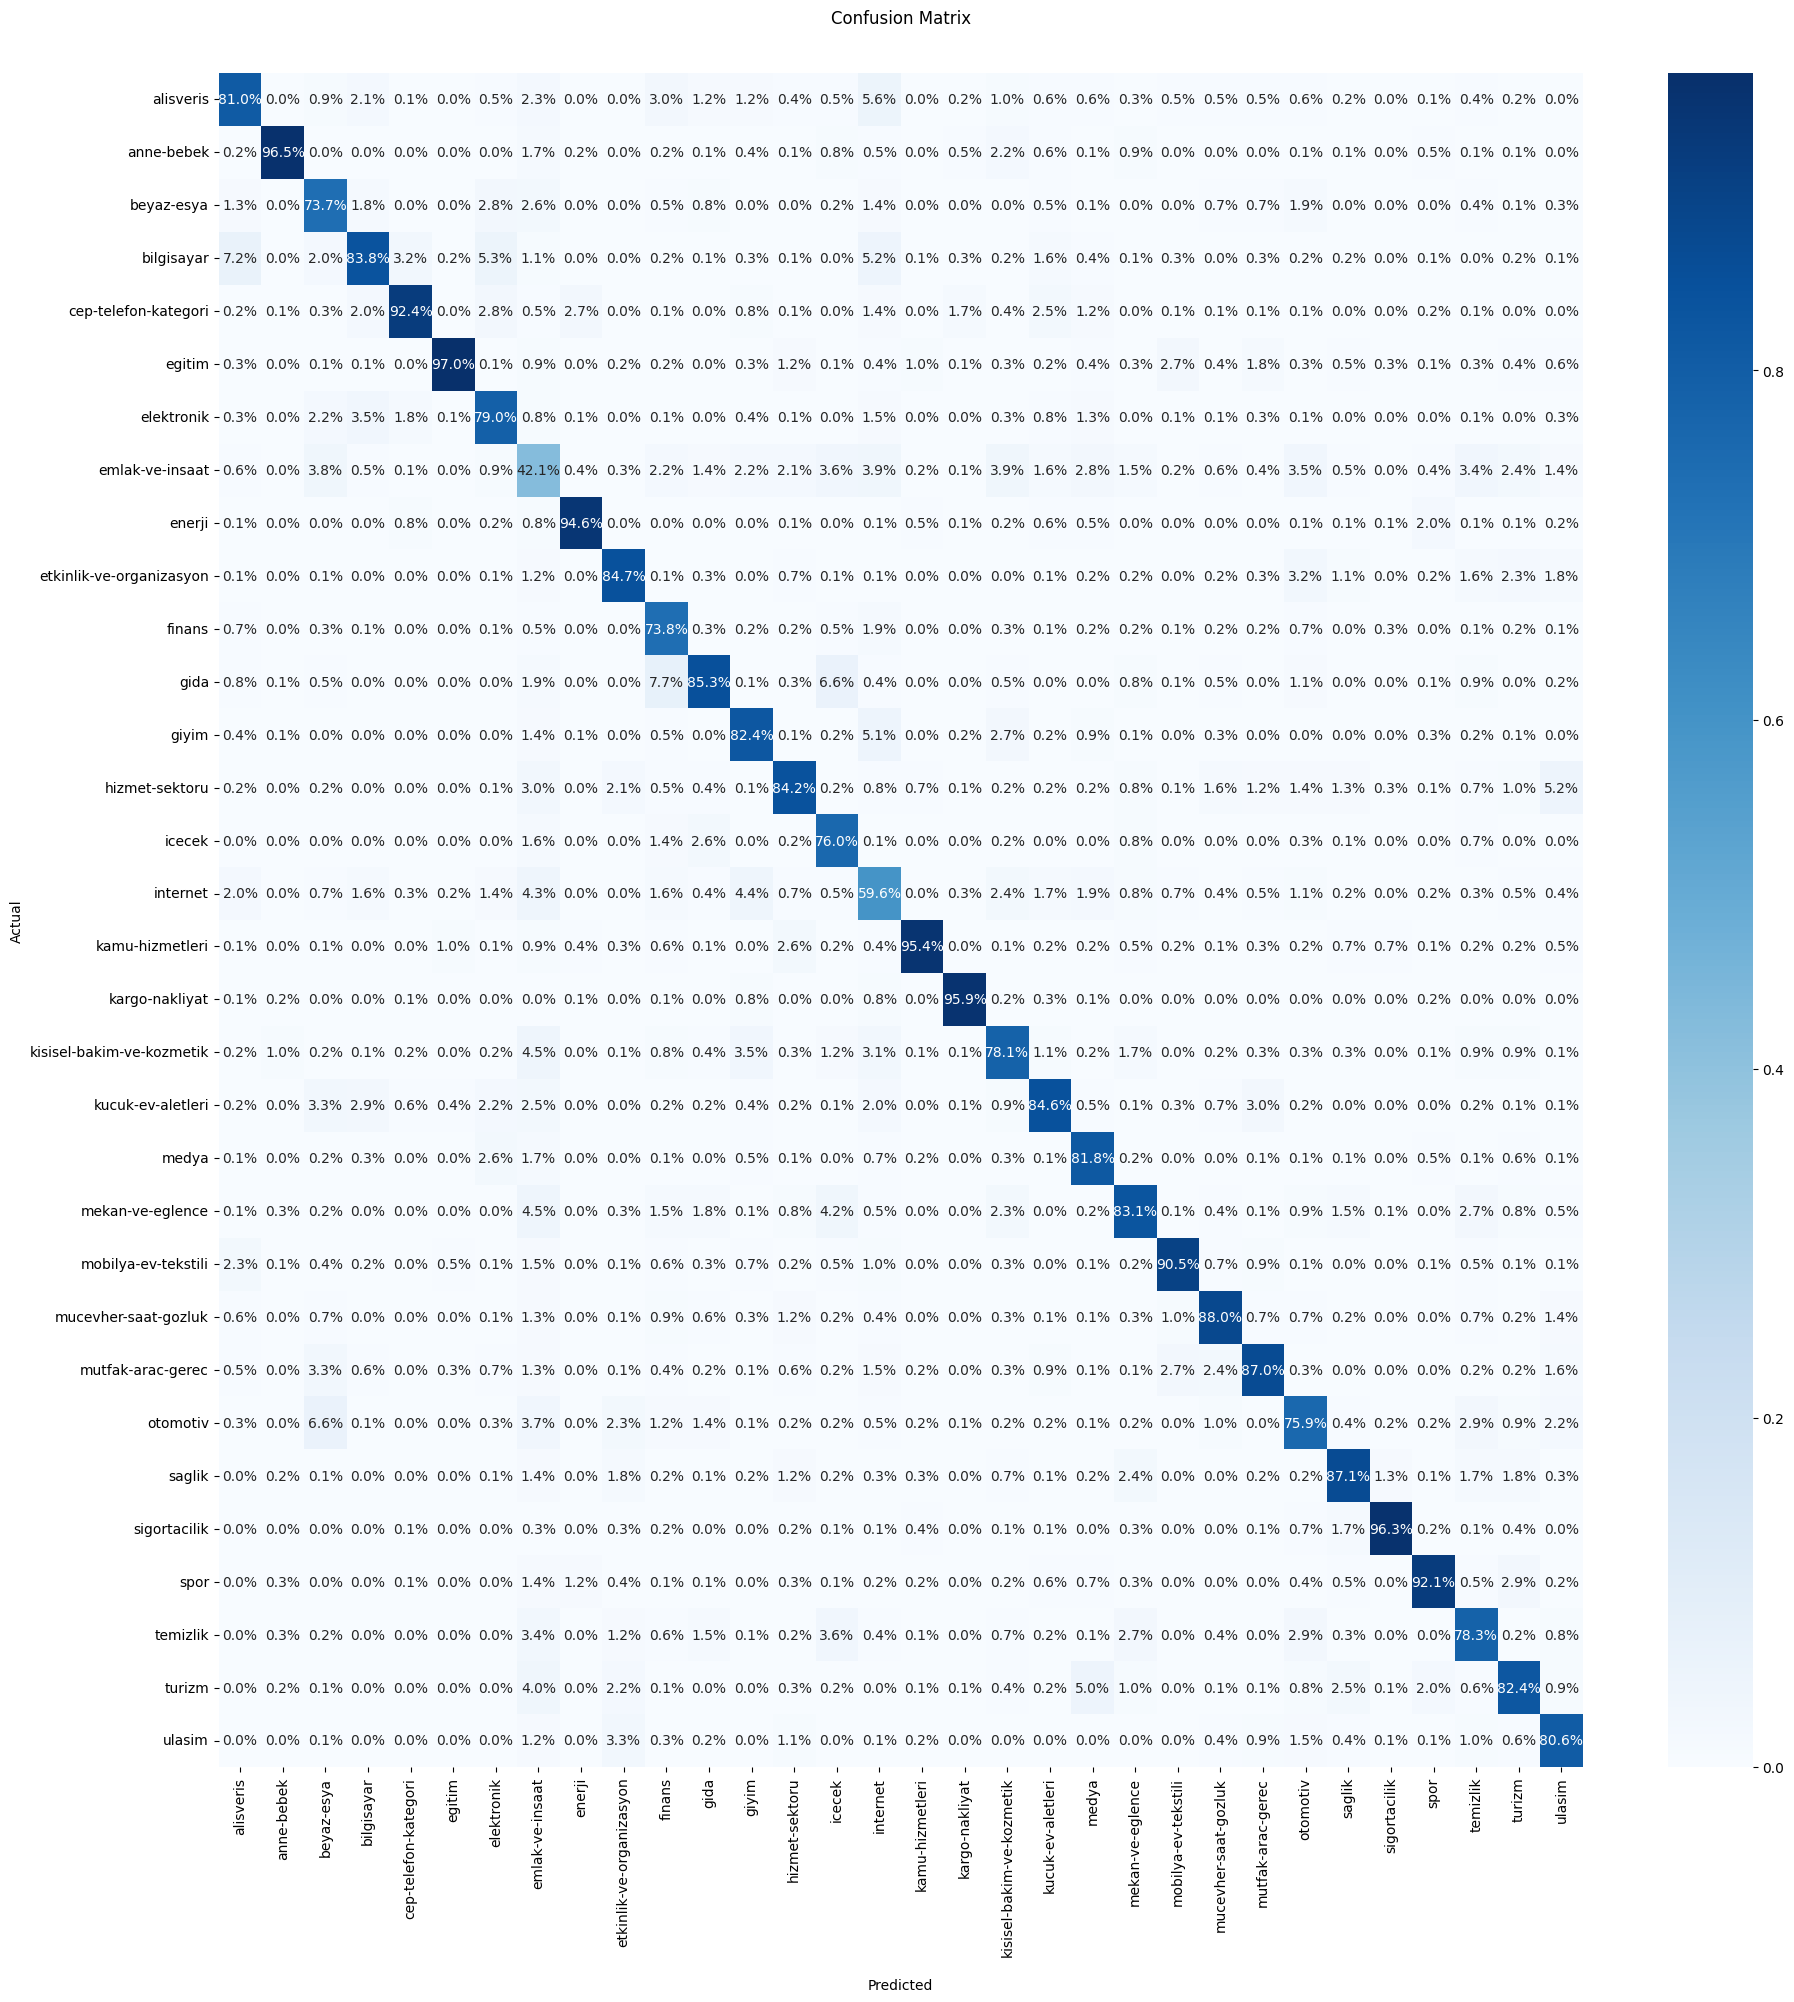

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(22,22))
ax = sns.heatmap(cm_df/np.sum(cm_df), annot=True, fmt='.1%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(id_to_category.values())
ax.yaxis.set_ticklabels(id_to_category.values())

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
end_to_end_model = tf.keras.Sequential([
  vectorize_layer,
  model_Conv1D,
  layers.Activation('softmax')
])

end_to_end_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam", metrics=['accuracy']
)

In [ ]:
loss, accuracy = end_to_end_model.evaluate(test_features, test_targets)
print("Test accuracy: ",accuracy)

2665/2665 [==============================] - 33s 12ms/step - loss: 1.0279 - accuracy: 0.8271
Test accuracy:  0.8271138668060303


In [ ]:
end_to_end_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 model_Conv1D (Functional)   (None, 32)                2008160   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
Total params: 2008160 (7.66 MB)
Trainable params: 2008160 (7.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf.keras.models.save_model(end_to_end_model, 'MCTC_Conv1D_E2E')

In [ ]:
!ls

MCTC_Conv1D_E2E  MultiClassTextClassification_BiLSTM  MultiClassTextClassification_FFN
model.png	 MultiClassTextClassification_Conv1D  vectorize_layer_model


In [ ]:
end_to_end_model= tf.keras.models.load_model('MCTC_Conv1D_E2E')

In [ ]:
examples = [
  "Bir fenomen aracılığı ile Yalova Terma City otel'den arandık. Tatil kazandınız buyurun 16 ocakta gelin dediler. Gittik (2 küçük çocuk, eşim ve annem ), bizi y** adlı kişi karşıladı. Tanıtım yapacağız 4 saat dedi. Daha odamıza bile geçemeden, dinlemeye fırsat vermeden bize oteli gezdirmeye başladılar. Gürültülü, müzik sesli, havasız, kalabalık (Corona olduğu dönemde) bir salonda bize tapulu 1 haftalık arsa sattılar. (psikolojik baskı ile) Tabi o yorgunlukla (amaçları da bu zaten) dinlenmeden bize otelin her detayını anlattılar. Tapumuzu almadan para istediler, güvendik aldık. IBAN numarası otele ait olmayan şahsa 30 bin tl ödedik. 1 gün sonra tapu işlemleri yapılacaktı istemiyoruz tapu, tatil dedik. Kabul etmiyorlar, paramızı vermiyorlar. Ayrıca annemin kaldığı odada ısıtma sistemi çalışmıyordu, çocuk havuzu aşırı pisti, kadınlara ait termal havuz kapalı idi, odada telefon çalışmıyordu ya da bilerek sessize alıyorlar ilgilenmemek için.",
  "5 yıl kullandığım buzdolabım buzluktan şu akıtmaya başladı. Servis geldi içini boşaltın. Lastiklerinden hava alıyor sıcak suyla lastikleri yıkayın dediler. Denileni yaptım. 1 sene olmadan tekrar akıtmaya başladı",
  "Hepsiburada'dan esofman takimi aldık. 18 ocakta yola çıktı ve teslim edildi gözüküyor. Teslim adresi kayınpederimin dükkandı. Ben elemanlar aldı diye düşündüm. Fakat birkaç gün geçti getiren olmadı. Sorunca da kimsenin teslim almadığını öğrendim. Lütfen kargomuzu kime teslim ettiğinizi öğrenin, o gün dağıtım yapan kuryenize sorabilirsiniz. Gereğinin yapılacağını umuyorum, kızıma aldığım bir hediyeydi üzgünüm.",
  "Bimcell tarafıma mesaj atıp 6GB internet Hediye! Evet yazıp 3121'e göndererek kampanyaya katilin,3 gün içinde 30 TL'ye Dost Orta Paket almanız karşılığında haftalık 6GB cepten internet kazanın! Şeklinde mesaj attı dediklerini yerine getirdim paketi yaptım 3121 e Evet yazarak mesaj attım ancak 24.01.2022 de yaptığım işlem hala gerçekleşmedi hediye 6 GB hattıma tanımlanmadı",
  "Instagram'da gözlük marketi hesabı sattığı kalitesiz ürünü geri almıyor. Gözlük çok kötü. Saplar oyuncak desen değil. Oyuncakçıdan alsam çok daha kaliteli olurdu. Bir yazdım iade edebilirsiniz diyor. Sonra yok efendim iademiz yok diyor.",
  "Tamamlayıcı sağlık sigortamı iptal etmek istiyorum fakat ne bankadan ne NN SİGORTA'dan bir tek muhatap bile bulamıyorum. Telefonda dakikalarca tuşlama yapıp bekletiliyor kimsenin cevap verdiği yok. Zaman kaybından başka bir şey değil! İletişim kurabileceğim biri tarafından aranmak istiyorum",
  "Selamlar TOKİ ve emlak yönetimden şikayetimiz var. Kastamonu merkez örencik TOKİ 316 konut 3 gündür kömür gelmedi bir çok blokta kömür bitmiş durumda bu kış zamanında eksi 8 ila 15 derecede yaşlılar hastalar çocuklar bütün herkesi mağdur ettiler. Emlak yönetim 734.60 ton kömür anlaşması yapmış onu da geç yaptığı için zaten yüksek maliyet çıkarmıştı yeni fiyat güncellemesi yapacakmış örneğin bana 6.160 TL nin üzerine fiyat eklenecekmiş bu işi yapan sorumlu kişi veya kişilerin zamanında tedbir almamasının cezasını TOKİ de oturan insanlar çekiyor ya sistem ya da kişiler hatalı"
]

predictions=end_to_end_model.predict(examples)
for pred in predictions:
  print(id_to_category[np.argmax(pred)])

1/1 [==============================] - 0s 129ms/step
turizm
emlak-ve-insaat
internet
kisisel-bakim-ve-kozmetik
internet
ulasim
gida


**Bölüm 7 Keras Bidirectional LSTM Katmanı ile Model Geliştirmek**

In [ ]:
embed_dim = 16  # Embedding size for each token
feed_forward_dim = 64  # Hidden layer size in feed forward network

def create_model_LSTM():
    inputs_tokens = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_layer = layers.Embedding(input_dim=vocab_size,
                                       output_dim=embed_dim,
                                       input_length=max_len)
    x = embedding_layer(inputs_tokens)
    #x = layers.Conv1D(256, kernel_size=5)(x)
    #x = layers.GRU(256, return_sequences=True)(x)
    #x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(feed_forward_dim, activation='relu')(x)
    x = layers.GlobalMaxPool1D()(x)
    outputs = layers.Dense(number_of_categories)(x)
    model = keras.Model(inputs=inputs_tokens,
                        outputs=outputs, name='model_LSTM')
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric_fn  = tf.keras.metrics.SparseCategoricalAccuracy()
    model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)

    return model
model_LSTM=create_model_LSTM()

In [ ]:
model_LSTM.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 40, 16)            1600000   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           279552    
                                                                 
 dropout_2 (Dropout)         (None, 40, 256)           0         
                                                                 
 dense_4 (Dense)             (None, 40, 64)            16448     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                        

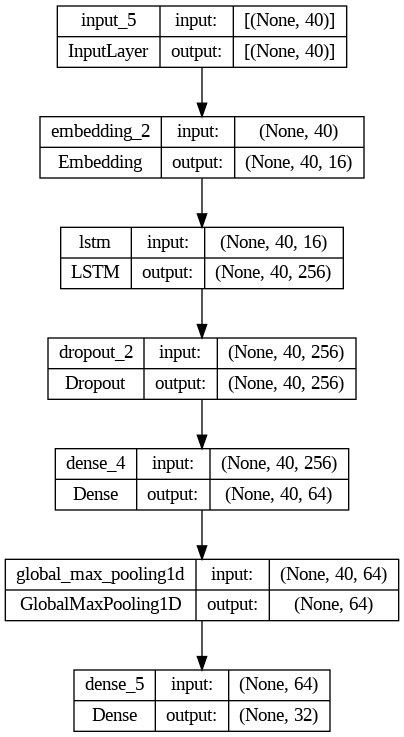

In [ ]:
tf.keras.utils.plot_model(model_LSTM,show_shapes=True)

In [ ]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/models


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 40), dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

In [ ]:
val_ds.element_spec

(TensorSpec(shape=(64, 40), dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

In [ ]:
for X, y in val_ds.take(1):
  print(X.shape, y.shape)
  print("All categories values in this batch: ", y)
  print("\nFirst sample in the batch:")
  print("\tX is: " ,X[0])
  print("\ty is: ", y[0].numpy)
  input = " ".join([vocab[_] for _ in np.squeeze(X[0])])
  output = id_to_category[y[0].numpy()]
  print("\tinput (in text): " , input)
  print("\toutput (in category): " , output)

  print("\nSecond sample in the batch:")
  print("\tX is: " ,X[1])
  print("\ty is: ", y[1].numpy)
  input = " ".join([vocab[_] for _ in np.squeeze(X[1])])
  output = id_to_category[y[1].numpy()]
  print("\tinput (in text): " , input)
  print("\toutput (in category): " , output)

(64, 40) (64,)
All categories values in this batch:  tf.Tensor(
[ 2 15 25 17  7  1 14  8 22 16 31 26  6 30 30  0  3 18 19 24  4 12 31 27
 28 25 17 14  5  9 17 14 28 29  9 31 24 11 21 29 11 10 21 12 26 23  5  1
 10  1 10  2  3 29  1  8 18 14  5 27 26  5  1 10], shape=(64,), dtype=int64)

First sample in the batch:
	X is:  tf.Tensor(
[ 1875  1656  1679   102   805   993    90  1092  1080   359    17  3711
     5    23   166    15  6271  7143     3    13    12   745     5  1600
 18525   109    21   398  2778   150    18   454 18163  2011   717   106
  1878  5320    54  3112], shape=(40,), dtype=int64)
	y is:  <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=int64, numpy=2>>
	input (in text):  kumtel montaj sirasinda ucret talebi bim den set ustu ocak aldim montaji icin musteri hizmetleri ile irtibat kurdum ve gun sonra kurulum icin geldiler gelenler ilk once yillik bina olmasina ragmen dogalgaz hortumunun degismesi lazim dediler itiraz edince geri adim
	output (in categ

In [ ]:
history=model_LSTM.fit(train_ds, validation_data=val_ds ,verbose=1, epochs=10)

Epoch 1/10
239/239 [==============================] - 36s 145ms/step - loss: 3.1130 - sparse_categorical_accuracy: 0.0721 - val_loss: 2.8090 - val_sparse_categorical_accuracy: 0.1058
Epoch 2/10
239/239 [==============================] - 34s 143ms/step - loss: 2.5696 - sparse_categorical_accuracy: 0.1440 - val_loss: 2.5354 - val_sparse_categorical_accuracy: 0.1773
Epoch 3/10
239/239 [==============================] - 34s 144ms/step - loss: 2.2098 - sparse_categorical_accuracy: 0.2260 - val_loss: 2.2702 - val_sparse_categorical_accuracy: 0.2764
Epoch 4/10
239/239 [==============================] - 34s 143ms/step - loss: 1.9242 - sparse_categorical_accuracy: 0.3184 - val_loss: 2.1389 - val_sparse_categorical_accuracy: 0.3269
Epoch 5/10
239/239 [==============================] - 35s 145ms/step - loss: 1.5095 - sparse_categorical_accuracy: 0.4645 - val_loss: 1.8643 - val_sparse_categorical_accuracy: 0.4561
Epoch 6/10
239/239 [==============================] - 34s 144ms/step - loss: 1.0541 -

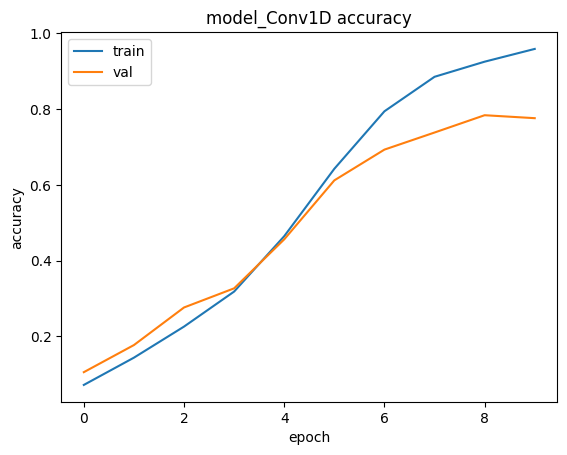

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model_Conv1D accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

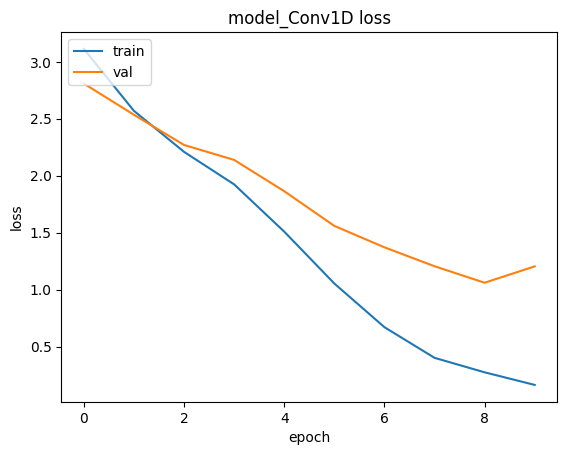

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_Conv1D loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
tf.keras.models.save_model(model_LSTM, 'MultiClassTextClassification_BiLSTM')

**Test**

In [ ]:
loss, accuracy = model_LSTM.evaluate(test_ds)
print("Test accuracy: ", accuracy)

1332/1332 [==============================] - 49s 36ms/step - loss: 1.1574 - sparse_categorical_accuracy: 0.7852
Test accuracy:  0.7852031588554382


**Tahmin**

In [ ]:
preds = model_LSTM.predict(test_ds)
preds = preds.argmax(axis=1)

1332/1332 [==============================] - 48s 36ms/step


In [ ]:
actuals = test_ds.unbatch().map(lambda x,y: y)
actuals=list(actuals.as_numpy_iterator())

**Sınıflandırma Raporu**

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, preds, digits=4))

              precision    recall  f1-score   support

           0     0.6623    0.7033    0.6822      2713
           1     0.7887    0.8801    0.8319      2460
           2     0.6909    0.7205    0.7054      2733
           3     0.5352    0.6468    0.5857      2562
           4     0.8984    0.8137    0.8539      2770
           5     0.6739    0.8550    0.7537      2620
           6     0.8108    0.6761    0.7373      2726
           7     0.3831    0.7390    0.5046      2379
           8     0.9302    0.9232    0.9267      2759
           9     0.9627    0.8627    0.9099      2694
          10     0.9163    0.8818    0.8987      2742
          11     0.7695    0.6735    0.7183      2603
          12     0.7702    0.8713    0.8177      2689
          13     0.7345    0.8034    0.7674      2579
          14     0.9717    0.8695    0.9178      2683
          15     0.5507    0.6461    0.5946      2690
          16     0.8562    0.7694    0.8105      2771
          17     0.9834    

**Karışıklık Matrisi**

In [ ]:
from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,
# which compares the y_test and y_pred
cm = confusion_matrix(actuals, preds)
cm_df = pd.DataFrame(cm, index = id_to_category.values() ,
                     columns = id_to_category.values())

In [ ]:
firstN=8
cm_df.iloc[:firstN , :firstN]

,alisveris,anne-bebek,beyaz-esya,bilgisayar,cep-telefon-kategori,egitim,elektronik,emlak-ve-insaat
alisveris,1908,60,25,48,3,16,12,118
anne-bebek,72,2165,3,4,0,4,0,29
beyaz-esya,111,6,1969,6,7,16,14,107
bilgisayar,12,1,25,1657,73,178,30,114
cep-telefon-kategori,23,0,36,33,2254,161,5,23
egitim,5,0,4,77,10,2240,0,56
elektronik,10,1,88,43,24,47,1843,63
emlak-ve-insaat,58,8,44,60,1,10,2,1758


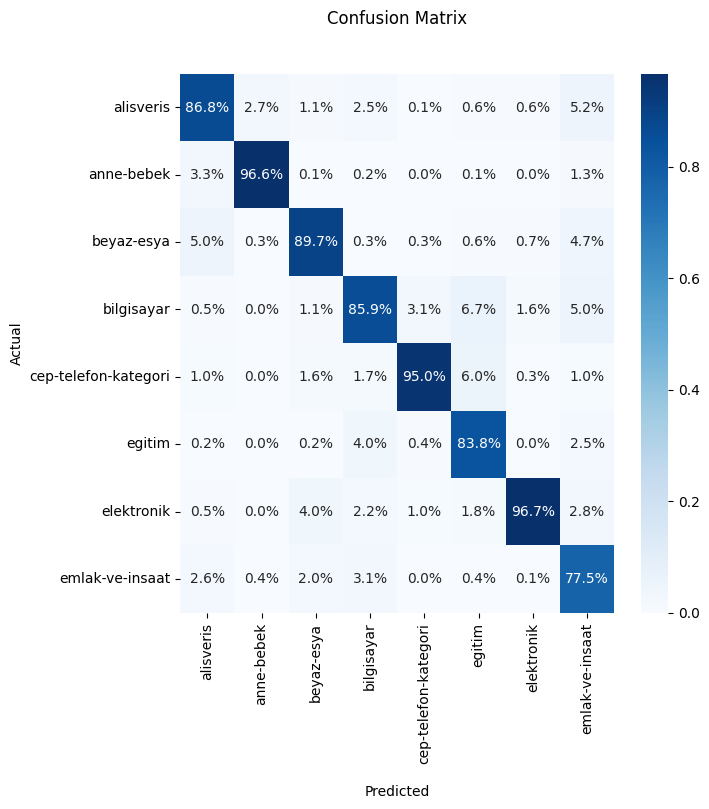

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))

ax = sns.heatmap(cm_df.iloc[:firstN ,
                            :firstN]/np.sum(cm_df.iloc[:firstN , :firstN]),
                 annot=True, fmt='.1%', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(list(id_to_category.values())[:firstN])
ax.yaxis.set_ticklabels(list(id_to_category.values())[:firstN])

## Display the visualization of the Confusion Matrix.
plt.show()

**Uçtan uca model ouşturma**

In [ ]:
end_to_end_model = tf.keras.Sequential([
  vectorize_layer,
  model_LSTM,
  layers.Activation('softmax')
])

end_to_end_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam", metrics=['accuracy']
)

In [ ]:
loss, accuracy = end_to_end_model.evaluate(test_features, test_targets)
print("Test accuracy: ",accuracy)

2665/2665 [==============================] - 66s 25ms/step - loss: 1.1573 - accuracy: 0.7852
Test accuracy:  0.7852234244346619


In [ ]:
end_to_end_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 model_LSTM (Functional)     (None, 32)                1898080   
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
Total params: 1898080 (7.24 MB)
Trainable params: 1898080 (7.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
examples = [
  "Bir fenomen aracılığı ile Yalova Terma City otel'den arandık. Tatil kazandınız buyurun 16 ocakta gelin dediler. Gittik (2 küçük çocuk, eşim ve annem ), bizi y** adlı kişi karşıladı. Tanıtım yapacağız 4 saat dedi. Daha odamıza bile geçemeden, dinlemeye fırsat vermeden bize oteli gezdirmeye başladılar. Gürültülü, müzik sesli, havasız, kalabalık (Corona olduğu dönemde) bir salonda bize tapulu 1 haftalık arsa sattılar. (psikolojik baskı ile) Tabi o yorgunlukla (amaçları da bu zaten) dinlenmeden bize otelin her detayını anlattılar. Tapumuzu almadan para istediler, güvendik aldık. IBAN numarası otele ait olmayan şahsa 30 bin tl ödedik. 1 gün sonra tapu işlemleri yapılacaktı istemiyoruz tapu, tatil dedik. Kabul etmiyorlar, paramızı vermiyorlar. Ayrıca annemin kaldığı odada ısıtma sistemi çalışmıyordu, çocuk havuzu aşırı pisti, kadınlara ait termal havuz kapalı idi, odada telefon çalışmıyordu ya da bilerek sessize alıyorlar ilgilenmemek için.",
  "5 yıl kullandığım buzdolabım buzluktan şu akıtmaya başladı. Servis geldi içini boşaltın. Lastiklerinden hava alıyor sıcak suyla lastikleri yıkayın dediler. Denileni yaptım. 1 sene olmadan tekrar akıtmaya başladı",
  "Hepsiburada'dan esofman takimi aldık. 18 ocakta yola çıktı ve teslim edildi gözüküyor. Teslim adresi kayınpederimin dükkandı. Ben elemanlar aldı diye düşündüm. Fakat birkaç gün geçti getiren olmadı. Sorunca da kimsenin teslim almadığını öğrendim. Lütfen kargomuzu kime teslim ettiğinizi öğrenin, o gün dağıtım yapan kuryenize sorabilirsiniz. Gereğinin yapılacağını umuyorum, kızıma aldığım bir hediyeydi üzgünüm.",
  "Bimcell tarafıma mesaj atıp 6GB internet Hediye! Evet yazıp 3121'e göndererek kampanyaya katilin,3 gün içinde 30 TL'ye Dost Orta Paket almanız karşılığında haftalık 6GB cepten internet kazanın! Şeklinde mesaj attı dediklerini yerine getirdim paketi yaptım 3121 e Evet yazarak mesaj attım ancak 24.01.2022 de yaptığım işlem hala gerçekleşmedi hediye 6 GB hattıma tanımlanmadı",
  "Instagram'da gözlük marketi hesabı sattığı kalitesiz ürünü geri almıyor. Gözlük çok kötü. Saplar oyuncak desen değil. Oyuncakçıdan alsam çok daha kaliteli olurdu. Bir yazdım iade edebilirsiniz diyor. Sonra yok efendim iademiz yok diyor.",
  "Tamamlayıcı sağlık sigortamı iptal etmek istiyorum fakat ne bankadan ne NN SİGORTA'dan bir tek muhatap bile bulamıyorum. Telefonda dakikalarca tuşlama yapıp bekletiliyor kimsenin cevap verdiği yok. Zaman kaybından başka bir şey değil! İletişim kurabileceğim biri tarafından aranmak istiyorum",
  "Selamlar TOKİ ve emlak yönetimden şikayetimiz var. Kastamonu merkez örencik TOKİ 316 konut 3 gündür kömür gelmedi bir çok blokta kömür bitmiş durumda bu kış zamanında eksi 8 ila 15 derecede yaşlılar hastalar çocuklar bütün herkesi mağdur ettiler. Emlak yönetim 734.60 ton kömür anlaşması yapmış onu da geç yaptığı için zaten yüksek maliyet çıkarmıştı yeni fiyat güncellemesi yapacakmış örneğin bana 6.160 TL nin üzerine fiyat eklenecekmiş bu işi yapan sorumlu kişi veya kişilerin zamanında tedbir almamasının cezasını TOKİ de oturan insanlar çekiyor ya sistem ya da kişiler hatalı"
]

predictions=end_to_end_model.predict(examples)
for pred in predictions:
  print(id_to_category[np.argmax(pred)])

1/1 [==============================] - 0s 396ms/step
bilgisayar
alisveris
internet
egitim
internet
medya
emlak-ve-insaat


In [ ]:
!pip uninstall gradio

Found existing installation: gradio 4.31.0
Uninstalling gradio-4.31.0:
  Would remove:
    /usr/local/bin/gradio
    /usr/local/bin/upload_theme
    /usr/local/lib/python3.10/dist-packages/gradio-4.31.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/gradio/*
Proceed (Y/n)? n


In [ ]:
!pip install gradio --quiet

In [ ]:
import gradio as gr

def classify(text):
    pred =end_to_end_model.predict([text])
    return id_to_category[np.argmax(pred)]


demo = gr.Interface(
    fn=classify,
    inputs=gr.Textbox(lines=5, label="Input Review"),
    outputs=gr.Textbox(label="Predicted Review Class"),
    examples=examples
)

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c61a15b4566e368122.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
